# Fan Sentiment vs Transfer Activity in the Premier League (Summer 2020)
This notebook analyzes how Premier League clubs' transfer activity
shapes fan sentiment on Twitter during the 2020 summer transfer window.

## 1. Loading the Twitter Sentiment Dataset

We start by downloading the two CSV files from the Kaggle dataset
`epl-teams-twitter-sentiment-dataset`. We then concatenate them into a single
DataFrame and keep only the columns needed for our analysis:

- `date`: timestamp of the tweet  
- `club`: club label inferred from file name  
- `user`: Twitter handle  
- `text`: tweet text  
- `retweets`: retweet count  
- `sentiment`: VADER compound score in \[-1, 1]

In [14]:
import os
import re
from io import StringIO
from collections import Counter, defaultdict
from itertools import combinations

import kagglehub
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# For VADER lexicon comparison
# If not installed, uncomment and run the next line ONCE:
# !pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

plt.style.use("default")

# 1. Load tweet dataset from Kaggle

We use the "EPL Teams Twitter Sentiment Dataset" from Kaggle.
It contains tweets mentioning Premier League clubs with precomputed
VADER sentiment scores ("polarity" = compound score in [-1, 1]).

In [15]:
path = kagglehub.dataset_download("wjia26/epl-teams-twitter-sentiment-dataset")
print("Path to dataset files:", path)

# Load both CSV files
csv1 = os.path.join(path, "2020-07-09 till 2020-09-19.csv")
csv2 = os.path.join(path, "2020-09-20 till 2020-10-13.csv")
df1 = pd.read_csv(csv1)
df2 = pd.read_csv(csv2)

# Combine into one DataFrame and keep relevant columns
df = pd.concat([df1, df2], ignore_index=True)
df = df[['created_at', 'file_name', 'username', 'text', 'retweet_count', 'polarity']]
df.columns = ['date', 'club', 'user', 'text', 'retweets', 'sentiment']  # 'sentiment' = VADER compound

print("Raw tweet data shape:", df.shape)
df.head()

Path to dataset files: /Users/christofferfrost/.cache/kagglehub/datasets/wjia26/epl-teams-twitter-sentiment-dataset/versions/2
Raw tweet data shape: (1010582, 6)


,date,club,user,text,retweets,sentiment
0,2020-07-09 11:34:08,Liverpool,Liverpool FC News,This is a strange claim #LFC https://t.co/U1...,0,-0.2023
1,2020-07-09 11:33:52,Liverpool,Ged Smith,RT @TheKopiteOFF: 😱| #LFC have won 30 of their...,65,0.8316
2,2020-07-09 11:33:52,Liverpool,DADA BA♐,RT @SkySportsPL: 🔴 - #LFC secure first away wi...,32,0.8793
3,2020-07-09 11:33:50,Liverpool,Ruairi Nolan,Outrageous... Poor auld Martin Tyler has to ju...,0,-0.6808
4,2020-07-09 11:33:31,Liverpool,🇮🇪 David D'Arcy 🇮🇪,RT @TheRedmenTV: ✅ Won the league ✅ Fastest te...,176,0.8176


# 2. Scrape transfer data from Wikipedia

We use the "List of English football transfers summer 2020" Wikipedia page.
Steps:
1. Download HTML (with User-Agent to avoid 403),
2. Keep only transfer-like tables,
3. Clean column names,
4. Filter to the same window as the tweets (27 July – 11 September 2020),
5. Keep only 20/21 Premier League clubs,
6. Parse transfer fees into million GBP and compute club-level spend.

In [16]:
url = "https://en.wikipedia.org/wiki/List_of_English_football_transfers_summer_2020"

headers = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/124.0.0.0 Safari/537.36"
    )
}

response = requests.get(url, headers=headers)
response.raise_for_status()
html = response.text

tables = pd.read_html(StringIO(html))
print(f"Total tables found on Wikipedia page: {len(tables)}")

# Keep only "transfer-like" tables (with date, from, to)
valid_tables = []
for t in tables:
    cols = [str(c).lower() for c in t.columns]
    has_date = any("date" in c for c in cols)
    has_from = any("from" in c for c in cols)
    has_to   = any("to"   in c for c in cols)
    if has_date and has_from and has_to:
        valid_tables.append(t)

print(f"Transfer-like tables kept: {len(valid_tables)}")

# Combine and drop completely empty columns
transfers_df = pd.concat(valid_tables, ignore_index=True)
transfers_df = transfers_df.dropna(axis=1, how="all")

# Standardise column names
rename_map = {}
date_assigned   = False
player_assigned = False
from_assigned   = False
to_assigned     = False
fee_assigned    = False

for c in transfers_df.columns:
    cl = str(c).lower()
    if ("date" in cl) and not date_assigned:
        rename_map[c] = "Date"
        date_assigned = True
    elif ("player" in cl) and not player_assigned:
        rename_map[c] = "Player"
        player_assigned = True
    elif ("from" in cl) and not from_assigned:
        rename_map[c] = "From club"
        from_assigned = True
    elif ("to" in cl) and not to_assigned:
        rename_map[c] = "To club"
        to_assigned = True
    elif ("fee" in cl) and not fee_assigned:
        rename_map[c] = "Fee"
        fee_assigned = True

transfers_df = transfers_df.rename(columns=rename_map)
transfers_df = transfers_df.loc[:, ~transfers_df.columns.duplicated()]

keep_cols = [c for c in ["Date", "Player", "From club", "To club", "Fee"] if c in transfers_df.columns]
transfers_df = transfers_df[keep_cols].copy()

print("Columns after cleaning:", transfers_df.columns.tolist())
print("Total raw transfer rows:", len(transfers_df))

# Parse dates & filter to same window as tweets
transfers_df["Date"] = pd.to_datetime(transfers_df["Date"], dayfirst=True, errors="coerce")
transfers_df = transfers_df.dropna(subset=["Date"])

start_date = "2020-07-27"
end_date   = "2020-09-11"
mask_dates = (transfers_df["Date"] >= start_date) & (transfers_df["Date"] <= end_date)
window_df = transfers_df[mask_dates].copy()

print("Transfer rows in date window:", len(window_df))

# Keep only 20/21 Premier League clubs (subset used in tweet data)
pl_clubs = {
    "Arsenal",
    "Manchester United",
    "Liverpool",
    "Manchester City",
    "Tottenham Hotspur",
    "Everton",
    "Chelsea",
    "Crystal Palace",
    "Leicester City",
    "Southampton",
    "Burnley",
}

mask_pl = window_df["From club"].isin(pl_clubs) | window_df["To club"].isin(pl_clubs)
pl_transfers = window_df[mask_pl].copy()
print("Transfer rows involving PL clubs:", len(pl_transfers))

# Function to parse fee strings -> million GBP
def parse_fee_to_million_gbp(fee_str):
    if pd.isna(fee_str):
        return np.nan
    s = str(fee_str).lower().strip()
    if any(w in s for w in ["loan", "free", "undisclosed", "end of loan", "released"]):
        return 0.0
    s_clean = s.replace(",", "")
    m = re.search(r"£\s*([\d\.]+)\s*(m|million)", s_clean)
    if m:
        return float(m.group(1))
    k = re.search(r"£\s*([\d\.]+)\s*(k|thousand)", s_clean)
    if k:
        return float(k.group(1)) / 1000.0
    n = re.search(r"£\s*([\d\.]+)", s_clean)
    if n:
        return float(n.group(1)) / 1_000_000.0
    return np.nan

pl_transfers["Fee_clean_mGBP"] = pl_transfers["Fee"].apply(parse_fee_to_million_gbp)

# Compute gross spend (only incoming transfers to PL clubs)
pl_buys = pl_transfers[pl_transfers["To club"].isin(pl_clubs)].copy()
club_spend = (
    pl_buys.groupby("To club")["Fee_clean_mGBP"]
    .sum()
    .sort_values(ascending=False)
)

print("\nTotal gross spend (million GBP):")
print(club_spend)

# Save transfer data to CSV (used later when merging)
pl_transfers.to_csv("pl_transfers_2020-07-27_to_2020-09-11.csv", index=False)
club_spend.to_csv("pl_club_spend_2020-07-27_to_2020-09-11.csv")
print("\nSaved transfer CSVs.")

Total tables found on Wikipedia page: 4
Transfer-like tables kept: 2
Columns after cleaning: ['Date', 'From club', 'To club', 'Fee']
Total raw transfer rows: 819
Transfer rows in date window: 361
Transfer rows involving PL clubs: 55

Total gross spend (million GBP):
To club
Chelsea              116.00
Manchester City       61.87
Everton               53.70
Manchester United     35.00
Arsenal               27.00
Leicester City        25.00
Southampton           22.90
Crystal Palace        19.50
Tottenham Hotspur     15.00
Liverpool             11.75
Burnley                0.00
Name: Fee_clean_mGBP, dtype: float64

Saved transfer CSVs.


## 3. Filter to the No-Match Transfer Window

We now:

1. Parse the tweet timestamps.
2. Drop rows with missing core metadata.
3. Restrict to the *no-match* transfer window:
   - Start: 27 July 2020 (day after the 19/20 season ends)
   - End:   11 September 2020 (day before the 20/21 season starts)

This isolates transfer-related discussion from reactions to on-pitch results.

In [17]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['club', 'user', 'text'])

start = pd.to_datetime("2020-07-27")
end   = pd.to_datetime("2020-09-11")
df = df[(df['date'] >= start) & (df['date'] <= end)].copy()

print(f"Filtered tweet dataset (no matches): {len(df):,} rows, {df.shape[1]} columns")
print(f"Size in memory: {round(df.memory_usage(deep=True).sum() / 1e6, 2)} MB")
print(f"Date range: {df['date'].min()} → {df['date'].max()}")
print(f"Unique clubs: {df['club'].nunique()}")
print("\nTweets per club:")
print(df['club'].value_counts())

Filtered tweet dataset (no matches): 446,475 rows, 6 columns
Size in memory: 243.79 MB
Date range: 2020-07-27 00:00:02 → 2020-09-10 23:59:55
Unique clubs: 12

Tweets per club:
club
Arsenal             79993
ManchesterUnited    78916
Liverpool           74239
ManchesterCity      50385
TottenhamHotspur    45118
Everton             35186
Chelsea             21931
CrystalPalace       21356
LeicesterCity       20254
Southampton          9456
AFC Bournemouth      6144
Burnley              3497
Name: count, dtype: int64


## 4. Building the Fan–Club Bipartite Network

We construct a bipartite network:

- One node partition: **fans** (Twitter users).
- Other partition: **clubs**.
- Undirected edge between fan and club if the user tweeted about that club at least once.
- Edge weight = number of tweets from that user mentioning that club.

This network is the backbone for our later network-based analyses.

In [18]:
G = nx.Graph()
for user, club in df[['user', 'club']].itertuples(index=False):
    if pd.isna(user) or pd.isna(club):
        continue
    G.add_node(user, bipartite='fan')
    G.add_node(club, bipartite='club')
    if G.has_edge(user, club):
        G[user][club]['weight'] += 1
    else:
        G.add_edge(user, club, weight=1)

fans = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'fan']
clubs = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'club']

print("\nNETWORK OVERVIEW (no-match transfer window)")
print(f"Total nodes: {G.number_of_nodes():,}")
print(f"Fans: {len(fans):,} | Clubs: {len(clubs):,}")
print(f"Edges (fan ↔ club): {G.number_of_edges():,}")


NETWORK OVERVIEW (no-match transfer window)
Total nodes: 127,138
Fans: 127,126 | Clubs: 12
Edges (fan ↔ club): 162,015


### 4.1 Visualizing the Bipartite Network

To better understand the network structure, we create a visualization of the fan-club connections.
Since the full network is too large to visualize effectively, we sample a subset of fans for clarity.

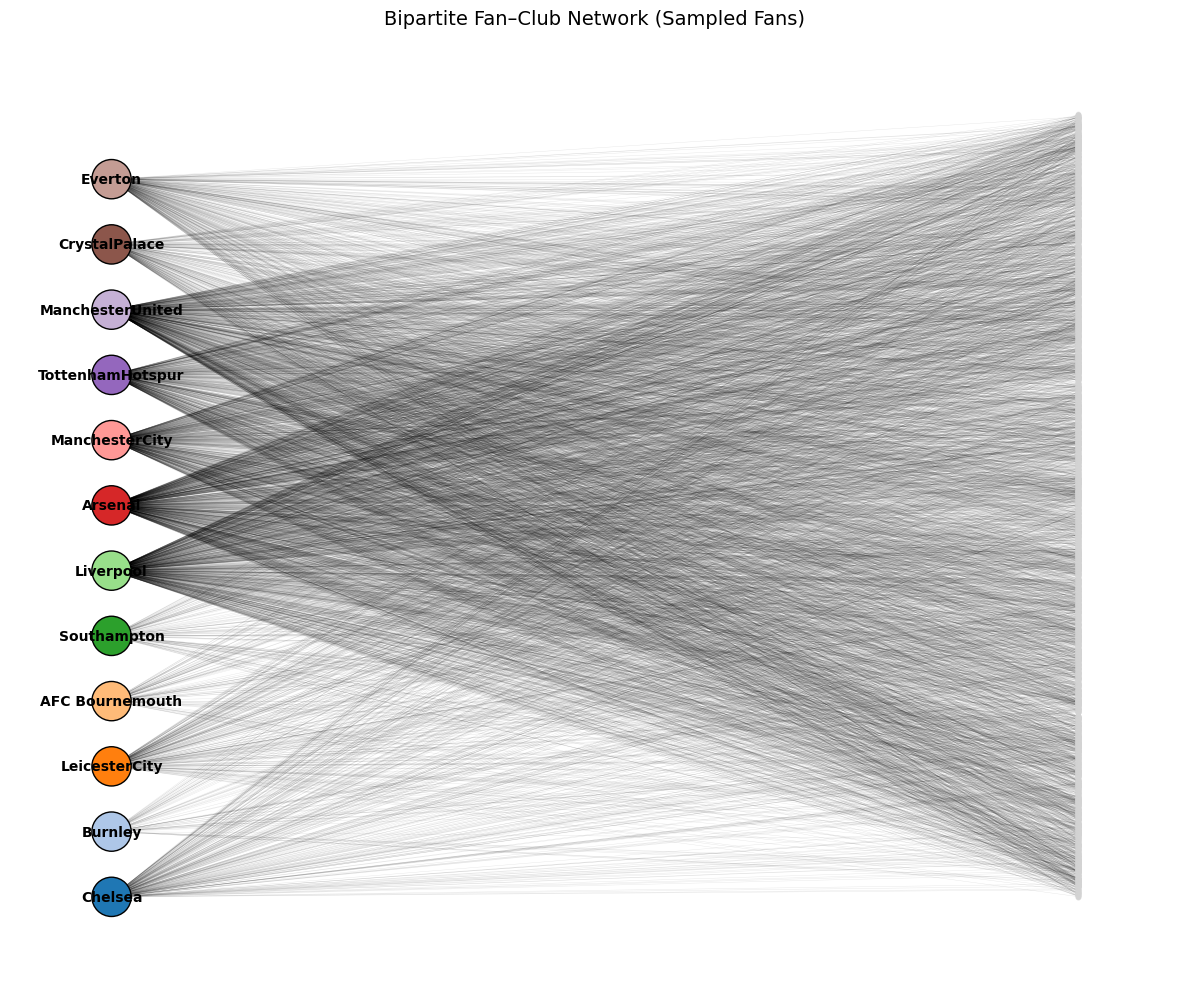

In [69]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# -----------------------------------------
# 1. Load your edges (fan → club)
# -----------------------------------------
# Assumes you have a dataframe `df` with columns: "user", "club"

# Extract unique clubs (these will NOT be sampled)
clubs = list(df['club'].unique())

# Map each club to a unique color
club_colors = {
    club: color for club, color in zip(clubs, plt.cm.tab20.colors[:len(clubs)])
}

# -----------------------------------------
# 2. Sample users so the plot is readable
# -----------------------------------------
unique_users = df['user'].unique()
sample_users = set(random.sample(list(unique_users), 4000))   # adjustable

df_sample = df[df['user'].isin(sample_users)]

# -----------------------------------------
# 3. Build bipartite graph
# -----------------------------------------
B = nx.Graph()

# Add club nodes
B.add_nodes_from(clubs, bipartite=0, type='club')

# Add fan nodes
B.add_nodes_from(sample_users, bipartite=1, type='fan')

# Add edges
edges = list(zip(df_sample['user'], df_sample['club']))
B.add_edges_from(edges)

# -----------------------------------------
# 4. Compute bipartite layout
# -----------------------------------------
pos = dict()

# Clubs on the left
for i, c in enumerate(clubs):
    pos[c] = (-1, i)

# Fans on the right, random vertical arrangement
for u in sample_users:
    pos[u] = (1, random.random() * len(clubs))

# -----------------------------------------
# 5. Draw the graph
# -----------------------------------------
plt.figure(figsize=(12, 10))

# Draw fans (grey)
nx.draw_networkx_nodes(B, pos,
                       nodelist=sample_users,
                       node_size=10,
                       node_color='lightgray',
                       alpha=0.5)

# Draw clubs (large colored nodes)
nx.draw_networkx_nodes(B, pos,
                       nodelist=clubs,
                       node_size=800,
                       node_color=[club_colors[c] for c in clubs],
                       edgecolors='black')

# Draw edges (thin, transparent)
nx.draw_networkx_edges(B, pos, width=0.3, alpha=0.1)

# Label clubs
nx.draw_networkx_labels(B, pos,
                        labels={c: c for c in clubs},
                        font_size=10,
                        font_weight="bold")

plt.title("Bipartite Fan–Club Network (Sampled Fans)", fontsize=14)
plt.axis('off')

plt.tight_layout()
plt.savefig("bipartite_network.png", dpi=300)
plt.show()

## 5. Club-Level Sentiment Summary

Next, we aggregate tweet-level sentiment to the club level.  
For each club we compute:

- Number of tweets (`tweets`)
- Average sentiment (`avg_sentiment`)
- Average retweets (`avg_retweets`)

This reproduces the descriptive table discussed in the Results section.


Top clubs by tweet count (VADER sentiment):
                club  tweets  avg_sentiment  avg_retweets
7          Liverpool   74239       0.271429    133.192204
5            Everton   35186       0.270679    106.048428
0    AFC Bournemouth    6144       0.243267     22.740723
9   ManchesterUnited   78916       0.229009    320.193700
1            Arsenal   79993       0.225329    201.126049
10       Southampton    9456       0.220887     39.965842
4      CrystalPalace   21356       0.214788    116.098989
8     ManchesterCity   50385       0.213904    450.954133
11  TottenhamHotspur   45118       0.211563    275.350060
2            Burnley    3497       0.200182      8.164999
3            Chelsea   21931       0.194625    135.298390
6      LeicesterCity   20254       0.187106    121.808680


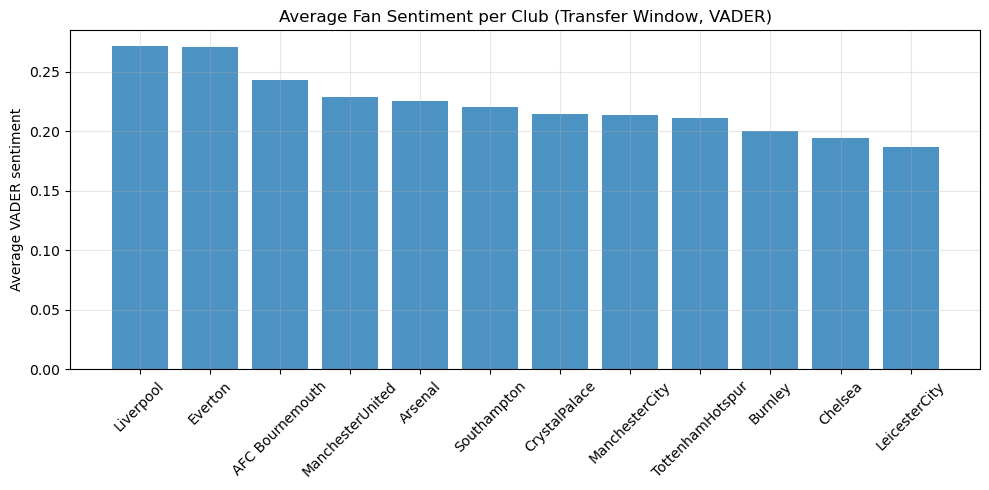

In [70]:
club_sent = df.groupby('club', as_index=False).agg(
    tweets=('text', 'count'),
    avg_sentiment=('sentiment', 'mean'),
    avg_retweets=('retweets', 'mean')
).sort_values('tweets', ascending=False)

club_sent = club_sent.sort_values('avg_sentiment', ascending=False)
print("\nTop clubs by tweet count (VADER sentiment):")
print(club_sent.head(12))

plt.figure(figsize=(10,5))
plt.bar(club_sent['club'], club_sent['avg_sentiment'], alpha=0.8)
plt.xticks(rotation=45)
plt.ylabel("Average VADER sentiment")
plt.title("Average Fan Sentiment per Club (Transfer Window, VADER)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Relating Transfer Spend to Average Fan Sentiment

We now merge:

- Club-level sentiment (from the Twitter dataset), and  
- Club-level transfer spend (from the scraped Wikipedia data).

Because club names may differ slightly in formatting between sources, we use a
canonical string key for matching. We then compute the Pearson correlation and
visualise the relationship between transfer spend and average sentiment.


Correlation between transfer spend and average VADER sentiment: -0.142


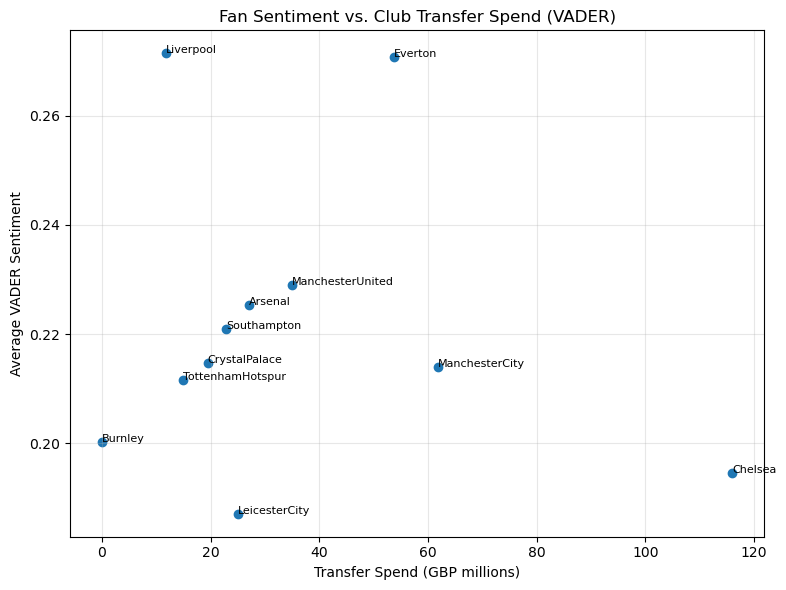

In [20]:
transfers_path = "pl_club_spend_2020-07-27_to_2020-09-11.csv"

if os.path.exists(transfers_path):
    spend = pd.read_csv(transfers_path)
    spend.columns = [c.strip().lower().replace(" ", "_") for c in spend.columns]
    spend = spend.rename(columns={"to_club": "club", "fee_clean_mgbp": "spend_gbp_m"})

    def canon(s):
        return re.sub(r'[^a-z0-9]+', '', str(s).lower())

    club_sent['_key'] = club_sent['club'].apply(canon)
    spend['_key'] = spend['club'].apply(canon)

    merged = pd.merge(
        club_sent,
        spend,
        on='_key',
        how='inner',
        suffixes=('', '_spend')
    )

    if 'club_spend' in merged.columns:
        merged['club'] = merged['club'].combine_first(merged['club_spend'])

    corr = merged[['avg_sentiment', 'spend_gbp_m']].corr(method='pearson').iloc[0, 1]
    print(f"\nCorrelation between transfer spend and average VADER sentiment: {corr:.3f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(merged['spend_gbp_m'], merged['avg_sentiment'])
    for _, r in merged.iterrows():
        plt.text(r['spend_gbp_m'], r['avg_sentiment'], r['club'], fontsize=8)
    plt.xlabel('Transfer Spend (GBP millions)')
    plt.ylabel('Average VADER Sentiment')
    plt.title('Fan Sentiment vs. Club Transfer Spend (VADER)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("\nCould not find club spend CSV to correlate with sentiment.")

## 7. Network Centrality in the Fan–Club Graph

We summarise the structure of the bipartite network:

- **Degree centrality** for clubs: proportion of fans connected to each club.
- **Strength** for clubs: total number of tweets (edge weights).
- For fans, we also compute degree and strength summary statistics.

These quantities help explain why certain clubs dominate the discussion.


Top clubs by degree centrality:
                club  degree_centrality  strength
6            Arsenal           0.219275     80172
9   ManchesterUnited           0.214808     78916
5          Liverpool           0.213400     74241
7     ManchesterCity           0.164830     50385
8   TottenhamHotspur           0.141005     45118
11           Everton           0.079096     35255
0            Chelsea           0.065009     22070
10     CrystalPalace           0.057521     21356
2      LeicesterCity           0.054327     20254
4        Southampton           0.028426      9456
3    AFC Bournemouth           0.023746      6144
1            Burnley           0.013041      3497

Fan degree stats:
Mean fan degree: 1.2742947941412457
Mean fan strength: 3.5090068121391376
Max fan strength: 3793


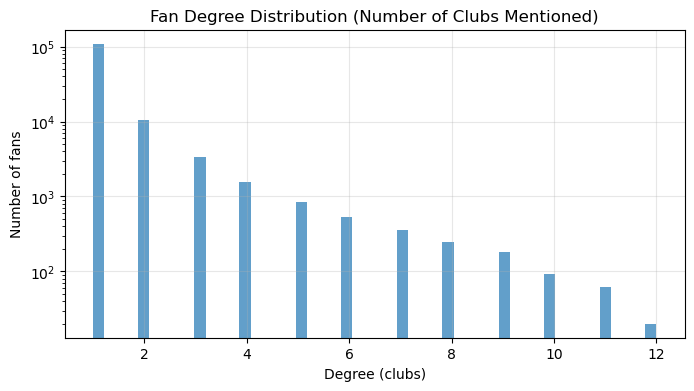

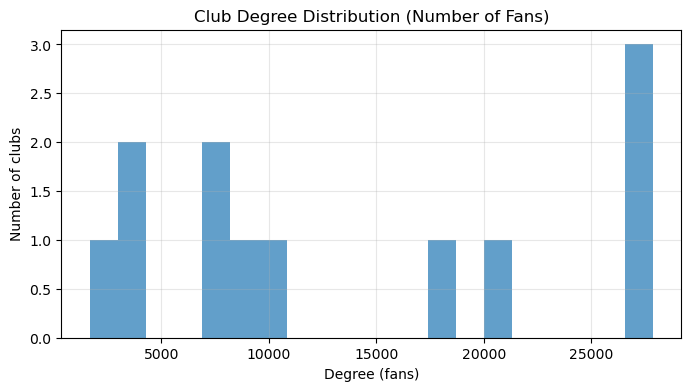

In [21]:
if len(G) == 0:
    raise ValueError("Graph G is empty. Make sure you built it from df first.")

deg_cent = nx.degree_centrality(G)
club_deg_cent = {c: deg_cent[c] for c in clubs}
club_strength = dict(G.degree(clubs, weight='weight'))

club_centrality_df = pd.DataFrame({
    "club": list(clubs),
    "degree_centrality": [club_deg_cent[c] for c in clubs],
    "strength": [club_strength[c] for c in clubs],
}).sort_values("degree_centrality", ascending=False)

print("\nTop clubs by degree centrality:")
print(club_centrality_df)

fan_deg_cent = {f: deg_cent[f] for f in fans}
fan_strength = dict(G.degree(fans, weight='weight'))

fan_cent_df = pd.DataFrame({
    "fan": list(fans),
    "degree_centrality": [fan_deg_cent[f] for f in fans],
    "strength": [fan_strength[f] for f in fans],
})

fan_degrees = np.array([G.degree(f) for f in fans])
club_degrees = np.array([G.degree(c) for c in clubs])

print("\nFan degree stats:")
print("Mean fan degree:", fan_degrees.mean())
print("Mean fan strength:", np.mean(list(fan_strength.values())))
print("Max fan strength:", max(list(fan_strength.values())))

plt.figure(figsize=(8,4))
plt.hist(fan_degrees, bins=50, alpha=0.7)
plt.title("Fan Degree Distribution (Number of Clubs Mentioned)")
plt.xlabel("Degree (clubs)")
plt.ylabel("Number of fans")
plt.yscale('log')
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(8,4))
plt.hist(club_degrees, bins=20, alpha=0.7)
plt.title("Club Degree Distribution (Number of Fans)")
plt.xlabel("Degree (fans)")
plt.ylabel("Number of clubs")
plt.grid(alpha=0.3)
plt.show()

## 8. VADER-Based Text Analysis: Positive vs Negative Words

We look at the most common words in clearly positive and clearly negative tweets
based on the original VADER sentiment to understand what language characterizes
fan reactions during the transfer window.

Top words in positive tweets (VADER):


,word,count
0,mufc,34459
1,this,30771
2,with,30053
3,arsenal,28681
4,have,24119
5,that,20801
6,united,18959
7,will,18136
8,season,17872
9,from,16852



Top words in negative tweets (VADER):


,word,count
0,mufc,6991
1,this,5565
2,arsenal,5553
3,that,5244
4,with,4899
5,have,4184
6,players,3775
7,season,3486
8,will,3326
9,they,3219


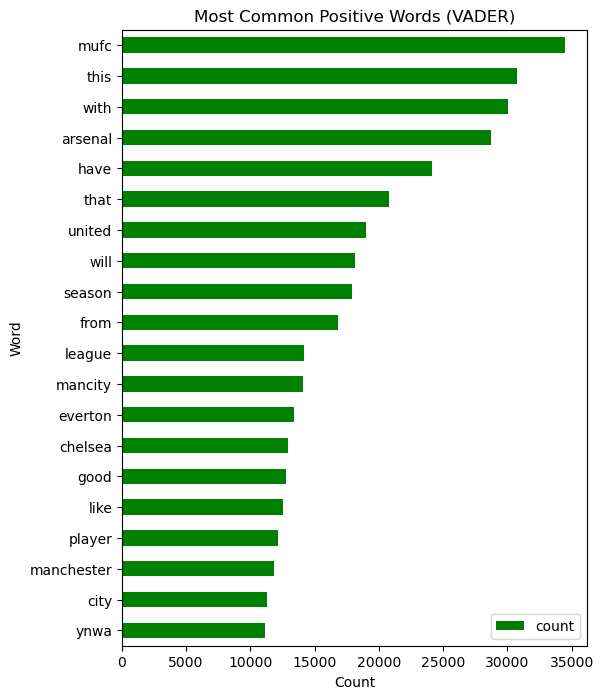

In [22]:
def simple_clean(text):
    text = text.lower()
    text = re.sub(r"http\S+","", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    return text

df['clean_text'] = df['text'].astype(str).apply(simple_clean)

pos_tweets = df[df['sentiment'] > 0.4]['clean_text']
neg_tweets = df[df['sentiment'] < -0.4]['clean_text']

def top_words(series, n=20):
    counter = Counter()
    for line in series:
        for w in line.split():
            if len(w) > 3:
                counter[w] += 1
    return pd.DataFrame(counter.most_common(n), columns=['word','count'])

top_pos_words_vader = top_words(pos_tweets, n=20)
top_neg_words_vader = top_words(neg_tweets, n=20)

print("Top words in positive tweets (VADER):")
display(top_pos_words_vader)

print("\nTop words in negative tweets (VADER):")
display(top_neg_words_vader)

top_pos_words_vader.plot(kind='barh', x='word', y='count', figsize=(6,8), color='green')
plt.title("Most Common Positive Words (VADER)")
plt.xlabel("Count")
plt.ylabel("Word")
plt.gca().invert_yaxis()
plt.show()


## 9. Self-Made Sentiment Model (Logistic Regression on TF-IDF)

We now train our own sentiment classifier on the tweets to compare with VADER.

**Training approach:**
- Labels: positive (VADER > 0.2), negative (VADER < -0.2)
- Neutral tweets are discarded from training
- Features: TF-IDF vectors (unigrams + bigrams)
- Model: Logistic Regression classifier

In [23]:
df_model = df.copy()
df_model = df_model[df_model["sentiment"].abs() > 0.2].copy()
df_model["label"] = (df_model["sentiment"] > 0.2).astype(int)

print("Training samples:", len(df_model))
print(df_model["label"].value_counts())

vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    min_df=10,
    max_df=0.8,
    ngram_range=(1,2)
)

X = vectorizer.fit_transform(df_model["text"].astype(str))
y = df_model["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = LogisticRegression(max_iter=300)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("\nSelf-made sentiment model performance:")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print(classification_report(y_test, y_pred))

Training samples: 267180
label
1    218784
0     48396
Name: count, dtype: int64

Self-made sentiment model performance:
Accuracy: 0.937
              precision    recall  f1-score   support

           0       0.93      0.71      0.80      9722
           1       0.94      0.99      0.96     43714

    accuracy                           0.94     53436
   macro avg       0.93      0.85      0.88     53436
weighted avg       0.94      0.94      0.93     53436



## 10. Word Importance in the Self-Made Model

We inspect the logistic regression coefficients to understand which words drive sentiment predictions:
- **Positive coefficients** → words strongly associated with positive sentiment
- **Negative coefficients** → words strongly associated with negative sentiment

In [24]:
feature_names = np.array(vectorizer.get_feature_names_out())
coef = clf.coef_[0]

word_importance = pd.DataFrame({
    "word": feature_names,
    "coef": coef
})

top_pos_words_ml = word_importance.sort_values("coef", ascending=False).head(25)
top_neg_words_ml = word_importance.sort_values("coef", ascending=True).head(25)

print("Top positive words (ML model):")
display(top_pos_words_ml)

print("\nTop negative words (ML model):")
display(top_neg_words_ml)

Top positive words (ML model):


,word,coef
7228,best,14.079153
22977,great,11.934844
55201,united,11.548488
32139,love,11.266974
58028,win,10.595942
20742,free,10.246931
22494,good,8.912331
7425,better,8.722919
23753,happy,8.557630
57570,welcome,8.492469



Top negative words (ML model):


,word,coef
43515,rejected,-12.624340
58951,worst,-10.369561
26140,injury,-10.021486
47688,shit,-9.793327
20997,fuck,-9.367411
24234,hell,-9.291012
19475,ffs,-8.813512
23959,hate,-8.338070
5682,attacker,-8.228392
6659,battle,-8.123458


## 11. Apply Self-Made Model to All Tweets

We predict the probability that each tweet is positive (label=1) using our trained model.
This becomes our self-made sentiment score `sentiment_ml` scaled from [0,1] to [-1,1] to match VADER's range.

In [27]:
df['text'] = df['text'].astype(str)
X_all = vectorizer.transform(df['text'])
# Predict probabilities for positive class (label=1)
df['sentiment_ml'] = clf.predict_proba(X_all)[:, 1]
# Scale from [0,1] to [-1,1] 
df['sentiment_ml_scaled'] = df['sentiment_ml'] * 2 - 1

print("\nCorrelation between VADER sentiment and ML sentiment:")
print(df["sentiment"].corr(df["sentiment_ml"]))

df[['text','sentiment','sentiment_ml']].head()


Correlation between VADER sentiment and ML sentiment:
0.7367598241112594


,text,sentiment,sentiment_ml
3400,£50 million for Chilwell? £90 million for Have...,0.7476,0.858620
3401,"Which #Chelsea player, past or present is this...",0.0000,0.857420
3402,AC Milan are getting closer to Tiemoué Bakayok...,0.8176,0.983652
3403,This is a brilliant 3 minute insight from the ...,0.8176,0.979351
3404,#InterMilan boss #AntonioConte makes N’Golo Ka...,0.0000,0.752090


## 12. Compare ML Sentiment vs VADER at the Word Level

We merge our ML model coefficients with the VADER lexicon to identify
words where the two approaches disagree the most. This reveals different
approaches to sentiment analysis.

In [28]:
vader = SentimentIntensityAnalyzer()
vader_lex = vader.lexicon
vader_df = pd.DataFrame(vader_lex.items(), columns=["word","vader_score"])

ml_vs_vader = word_importance.merge(
    vader_df,
    on="word",
    how="inner"
)

ml_vs_vader["difference"] = ml_vs_vader["coef"] - ml_vs_vader["vader_score"]

print("Words the ML model sees as much more positive than VADER:")
display(ml_vs_vader.sort_values("difference", ascending=False).head(20))

print("\nWords the ML model sees as much more negative than VADER:")
display(ml_vs_vader.sort_values("difference").head(20))

Words the ML model sees as much more positive than VADER:


,word,coef,vader_score,difference
179,best,14.079153,3.2,10.879153
1706,united,11.548488,1.8,9.748488
796,great,11.934844,3.1,8.834844
1071,love,11.266974,3.2,8.066974
724,free,10.246931,2.3,7.946931
1775,win,10.595942,2.8,7.795942
783,good,8.912331,1.9,7.012331
998,join,8.146658,1.2,6.946658
181,better,8.722919,1.9,6.822919
882,hope,8.489071,1.9,6.589071



Words the ML model sees as much more negative than VADER:


,word,coef,vader_score,difference
1337,rejected,-12.624340,-2.3,-10.324340
954,injury,-10.021486,-1.8,-8.221486
1801,worst,-10.369561,-3.1,-7.269561
1464,shit,-9.793327,-2.6,-7.193327
747,fuck,-9.367411,-2.5,-6.867411
165,battle,-8.123458,-1.6,-6.523458
1038,leaked,-7.677575,-1.3,-6.377575
1468,shock,-7.961994,-1.6,-6.361994
130,attacking,-8.121302,-2.0,-6.121302
686,ffs,-8.813512,-2.8,-6.013512


## 13. Club-Level Sentiment: ML vs VADER Comparison

We compute average sentiment per club using both approaches:
- **VADER** (`sentiment`) - lexicon-based approach  
- **Our self-made model** (`sentiment_ml`) - machine learning approach

This allows us to compare how different sentiment methods affect our conclusions.


Club sentiment based on self-made model:
                club  tweets  avg_sentiment_ml  avg_retweets
1            Arsenal   79993          0.796925    201.126049
9   ManchesterUnited   78916          0.771316    320.193700
7          Liverpool   74239          0.814403    133.192204
8     ManchesterCity   50385          0.797009    450.954133
11  TottenhamHotspur   45118          0.794007    275.350060
5            Everton   35186          0.819265    106.048428
3            Chelsea   21931          0.794854    135.298390
4      CrystalPalace   21356          0.794778    116.098989
6      LeicesterCity   20254          0.785171    121.808680
10       Southampton    9456          0.817676     39.965842
0    AFC Bournemouth    6144          0.802768     22.740723
2            Burnley    3497          0.793943      8.164999

Club-level sentiment comparison (ML - VADER rescaled):


,club,tweets,avg_sentiment_ml,avg_retweets,avg_sentiment_vader,vader_rescaled,diff_ml_minus_vader
9,Southampton,9456,0.817676,39.965842,0.220887,0.610443,0.207233
6,Chelsea,21931,0.794854,135.298390,0.194625,0.597313,0.197542
11,Burnley,3497,0.793943,8.164999,0.200182,0.600091,0.193852
8,LeicesterCity,20254,0.785171,121.808680,0.187106,0.593553,0.191618
3,ManchesterCity,50385,0.797009,450.954133,0.213904,0.606952,0.190057
4,TottenhamHotspur,45118,0.794007,275.350060,0.211563,0.605781,0.188225
7,CrystalPalace,21356,0.794778,116.098989,0.214788,0.607394,0.187384
0,Arsenal,79993,0.796925,201.126049,0.225329,0.612665,0.184261
5,Everton,35186,0.819265,106.048428,0.270679,0.635339,0.183925
10,AFC Bournemouth,6144,0.802768,22.740723,0.243267,0.621634,0.181134


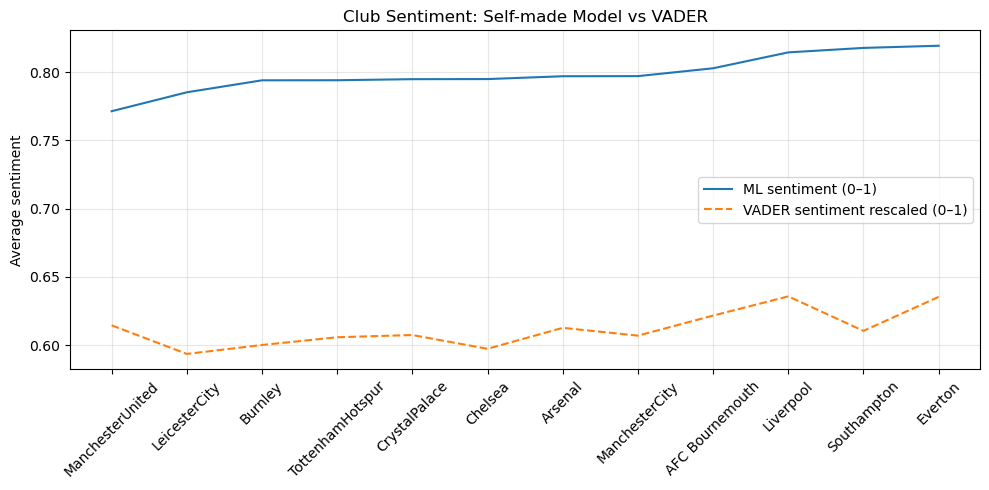

In [29]:
club_sent_ml = df.groupby('club', as_index=False).agg(
    tweets=('text', 'count'),
    avg_sentiment_ml=('sentiment_ml', 'mean'),
    avg_retweets=('retweets', 'mean')
).sort_values('tweets', ascending=False)

print("\nClub sentiment based on self-made model:")
print(club_sent_ml.head(12))

club_sent_vader = df.groupby('club', as_index=False)['sentiment'].mean().rename(columns={'sentiment':'avg_sentiment_vader'})

club_compare = club_sent_ml.merge(club_sent_vader, on='club')
# Rescale VADER from [-1,1] to [0,1] to compare with ML probabilities
club_compare['vader_rescaled'] = (club_compare['avg_sentiment_vader'] + 1) / 2
club_compare['diff_ml_minus_vader'] = club_compare['avg_sentiment_ml'] - club_compare['vader_rescaled']

print("\nClub-level sentiment comparison (ML - VADER rescaled):")
display(club_compare.sort_values('diff_ml_minus_vader', ascending=False))

plt.figure(figsize=(10,5))
clubs_sorted = club_compare.sort_values('avg_sentiment_ml')['club']

plt.plot(clubs_sorted, club_compare.set_index('club').loc[clubs_sorted, 'avg_sentiment_ml'],
         label='ML sentiment (0–1)')
plt.plot(clubs_sorted, club_compare.set_index('club').loc[clubs_sorted, 'vader_rescaled'],
         label='VADER sentiment rescaled (0–1)', linestyle='--')

plt.xticks(rotation=45)
plt.ylabel("Average sentiment")
plt.title("Club Sentiment: Self-made Model vs VADER")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

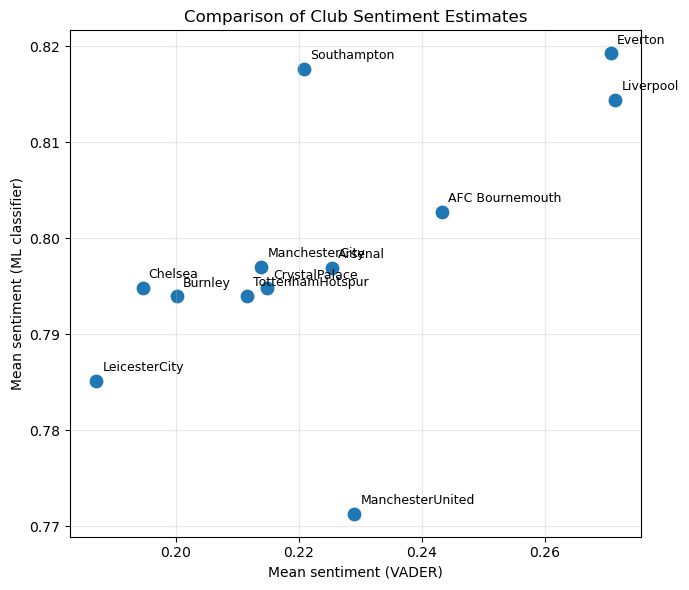

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
plt.scatter(
    club_compare['avg_sentiment_vader'],
    club_compare['avg_sentiment_ml'],
    s=80
)

for _, row in club_compare.iterrows():
    plt.text(
        row['avg_sentiment_vader'] + 0.001,
        row['avg_sentiment_ml'] + 0.001,
        row['club'],
        fontsize=9
    )

plt.xlabel('Mean sentiment (VADER)')
plt.ylabel('Mean sentiment (ML classifier)')
plt.title('Comparison of Club Sentiment Estimates')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('sentiment_comparison_scatter.png', dpi=300)
plt.show()


## 14. Most Positive/Negative Tweets According to Self-Made Model

Let's examine the extreme cases - tweets that our ML model rates as most positive 
and most negative to understand what language drives these classifications.

In [67]:
top_pos_ml = df.sort_values('sentiment_ml', ascending=False)[
    ['club','user','text','retweets','sentiment_ml']
].head(10)

top_neg_ml = df.sort_values('sentiment_ml', ascending=True)[
    ['club','user','text','retweets','sentiment_ml']
].head(10)

pd.set_option('display.max_colwidth', None)
print("Most positive tweets according to self-made model:")
display(top_pos_ml)

print("\nMost negative tweets according to self-made model:")
display(top_neg_ml)

Most positive tweets according to self-made model:


,club,user,text,retweets,sentiment_ml
411808,Arsenal,𝗖𝗵𝗲𝘆𝗣𝗼𝗹𝗮𝗿,@WinderDad I’m good thanks! Hope you’re well! #coyg,0,0.999998
293921,Liverpool,Nao,"I have to say I really truly am grateful to meet awesome #LFC 🔴friends🔴 U guys are super witty intelligent funny smart nice good hearted great spirit just the list goes on!! Thank u for making me laugh and share the moments, 🔴🤣👍 The best club 🔴 the greatest fans #LFC https://t.co/CjXOS4wgCX",0,0.999998
791378,Liverpool,Kevin Taylor,"@J_Smith55 Good owner, great staff working for the club, great ground, huge support, the best manager, a squad that has won so much, still ambitious, wonderful times. #YNWA",0,0.999997
289769,Liverpool,niran. 🇺🇸,"Overall, everyone go wish @TheOfficialFNG a happy 23rd birthday, he deserves all the best he can get! Thank you all and I hope you have a great night. #forzaniran #ynwa",2,0.999996
64808,Liverpool,ㅆ,RT @Normsi2: @JHenderson @officialAL20 This is so special #JH14 ❤ Wishing #AL14 all the best! Great number that 1️⃣4️⃣ Hope his future is a…,1,0.999991
235927,Liverpool,Takalani Lufhugu Jr.,@Cfa89 Happy Birthday Red. Hope you had a lovely one 🍰🎂🎊... #YNWA,1,0.999990
325042,Arsenal,ben goshorn,RT @andrew_the_pom: Unashamedly posting this again cos I love puns and I'm proud of this one... Love you @Aubameyang7 .. hope you're stayin…,1,0.999990
547805,Arsenal,Ahmed,"August 30th was my birthday and I received the best gift ever, thank you ARSENAL you made me happy, you're my first love, I loved you since 2005 and this love will be forever one and only. we will be better together. #COYG Credit for @ThierryHenry @cesc4official @Arsenal https://t.co/t1MD9l7ABC",0,0.999988
277101,Liverpool,♍NORMA❤GB🎹⫩💚LFC❤,@JHenderson @officialAL20 This is so special #JH14 ❤ Wishing #AL14 all the best! Great number that 1️⃣4️⃣ Hope his future is a very Bright-on(e) #YNWA ❤ https://t.co/BOpBKXGll1,1,0.999987
527653,Liverpool,Davinlan Vos - LFC Champ19ns❤️,"@Thokobaby1 @Bobby4Ballondor @DarkSideKopite @bmkbrunner @adamjoh36211398 @DoopLfc @FardielFma @Galv_LFC @hklLFC @INKLFC @jplfc2 @KtfLfc @LFC_PATH @LFC_Rodney @lfc_watch @LfcAsim @Thokobaby1 Thanks for S/O nice one 👍 appreciated 👊🏼 Morning reds ❤️ Hope everyone had a good week, wishing you all an awesome, chilled, relaxed fun filled weekend - enjoy. Keep safe &amp; well. Take care. #champions #winners #legends #YNWA #LFC #LFCFamily #Unbearables #Klopp https://t.co/gFJ4aOzg1q",0,0.999986



Most negative tweets according to self-made model:


,club,user,text,retweets,sentiment_ml
605934,CrystalPalace,Paul Ashby,"Oh ffs, it's gone from kit hate to wilf hate now. Fuck our lot are temperamental, #cpfc",1,0.000052
41609,ManchesterCity,Ryan #Mcfc,No shit. Ffs. 🤦🏽‍♂️🤣 #MCFC https://t.co/HmeuynTaMZ,0,0.000053
194743,ManchesterUnited,Kuro Ansokubi,Fuck this shit. Fuck everything. #mufc https://t.co/XYeXBXo85m,0,0.000059
578639,TottenhamHotspur,Suhel Ahmed,"Spurs Twitter has been unbearable for last two days and nights...fuck me, trust me to stuck indoors!! I hate it around this time...at least I could have been out and avoid this shit. Unfortunately stuck with nothing to do so keep browsing this shit! #COYS #THFC #StuckInDoors",0,0.000066
556674,Liverpool,Sir Nobody,"Can we jus cancel international football now...sooo shit. I hate that #lfc have so many english players, they risk injury for this dead-ass team and tournament. #ICEENG",1,0.000119
36086,ManchesterUnited,Steven Russell,Low and behold the window is a shambles again getting tired of this shit every fucking summer now piss poor #MUFC,0,0.000155
561176,TottenhamHotspur,Mark |/,How the actual hell are we losing to shit Watford?! #THFC,0,0.000156
123482,ManchesterCity,왕감자,"Fuck me, that was awful #mcfc",0,0.000163
72568,Liverpool,Paul Deaney,@Scouse1da It's so shit and only going to get worse !!#YNWA,0,0.000187
149800,Liverpool,Craig,"@JackSear Unfortunately another reason why Shaq has to be sold.. His injury record is awful, such a shame 😢 #YNWA",0,0.000264


## 15. Transfer Spend vs Sentiment (Self-Made Model)

We redo the spend-vs-sentiment analysis using our ML sentiment instead of VADER
to see if our conclusions about "spending buying happiness" change with different
sentiment measurement approaches.

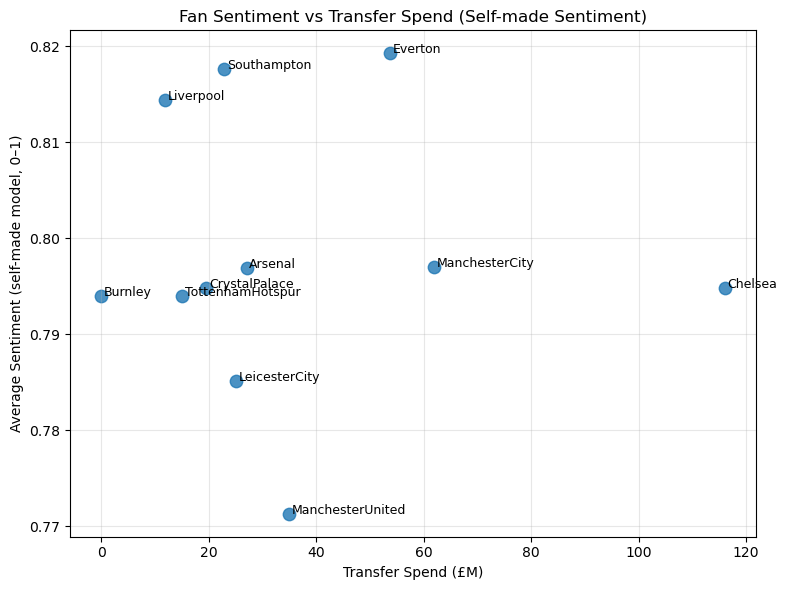

Correlation (self-made sentiment vs spend): -0.021


In [31]:
club_sent_ml_small = club_sent_ml[['club','avg_sentiment_ml']]

merged_ml = merged.merge(club_sent_ml_small, on='club', how='left')

plt.figure(figsize=(8,6))
plt.scatter(merged_ml['spend_gbp_m'], merged_ml['avg_sentiment_ml'], s=80, alpha=0.8)
for _, row in merged_ml.iterrows():
    plt.text(row['spend_gbp_m']+0.5, row['avg_sentiment_ml'], row['club'], fontsize=9)

plt.xlabel("Transfer Spend (£M)")
plt.ylabel("Average Sentiment (self-made model, 0–1)")
plt.title("Fan Sentiment vs Transfer Spend (Self-made Sentiment)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

corr_ml = merged_ml['spend_gbp_m'].corr(merged_ml['avg_sentiment_ml'])
print("Correlation (self-made sentiment vs spend):", round(corr_ml, 3))

## 16. Temporal Dynamics with Self-Made Sentiment

We compute daily average sentiment per club using our ML model and
plot time series for the top-spending clubs to observe sentiment changes
over time during the transfer window.

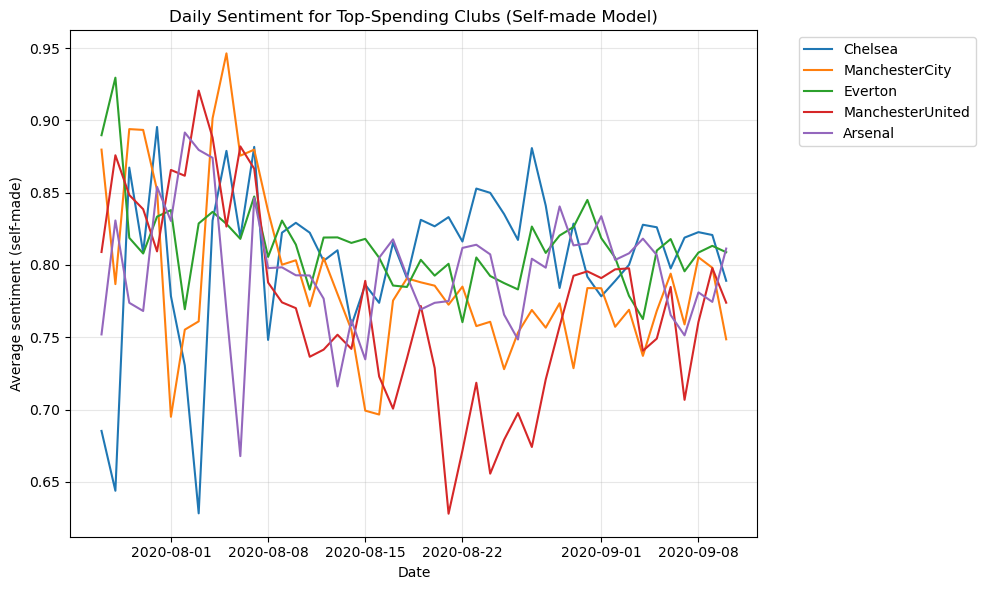

In [32]:
df['day'] = df['date'].dt.date

daily_sent_ml = df.groupby(['club','day'])['sentiment_ml'].mean().reset_index()

top_spenders = merged.sort_values('spend_gbp_m', ascending=False)['club'].head(5).tolist()

plt.figure(figsize=(10,6))
for club_name in top_spenders:
    sub = daily_sent_ml[daily_sent_ml['club'] == club_name]
    plt.plot(sub['day'], sub['sentiment_ml'], label=club_name)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Date")
plt.ylabel("Average sentiment (self-made)")
plt.title("Daily Sentiment for Top-Spending Clubs (Self-made Model)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [33]:

cols_to_export = [
    "date",
    "club",
    "user",
    "text",
    "retweets",
    "sentiment",      # VADER sentiment from dataset
    "sentiment_ml"    # self-made ML sentiment (0–1)
]

tweet_export = df[cols_to_export].copy()

# Save to CSV
tweet_export.to_csv("tweets_with_sentiment.csv", index=False, encoding="utf-8")

print("Saved", len(tweet_export), "rows to 'tweets_with_sentiment.csv'")


Saved 446475 rows to 'tweets_with_sentiment.csv'


## 17. Export Tweet Data with Both Sentiment Scores

We save the tweet-level data with both VADER and ML sentiment scores to a CSV file
for potential future analysis or sharing.

In [34]:


# Get connected components
components = list(nx.connected_components(G))
components_sizes = [len(c) for c in components]

print("Number of connected components in fan–club network:", len(components))
print("Sizes of first 10 components:", components_sizes[:10])

# Giant component
giant = max(components, key=len)
G_giant = G.subgraph(giant).copy()

print("Giant component size (nodes):", G_giant.number_of_nodes())
print("Giant component size (edges):", G_giant.number_of_edges())


Number of connected components in fan–club network: 1
Sizes of first 10 components: [127138]
Giant component size (nodes): 127138
Giant component size (edges): 162015
Giant component size (nodes): 127138
Giant component size (edges): 162015


# Advanced Network Analysis

## 18. Connected Components and Giant Component

We examine the network structure by identifying connected components
and focusing on the largest connected subgraph (giant component).

In [35]:
# %% [markdown]
# ### Extra: Club–club projection (shared-fan network)

from collections import Counter
from itertools import combinations

# Unique clubs mentioned per fan
user_clubs = (
    df.groupby('user')['club']
      .unique()
      .reset_index()
)

pair_counts = Counter()
for clubs_list in user_clubs['club']:
    clubs_list = list(set(clubs_list))
    if len(clubs_list) < 2:
        continue
    for a, b in combinations(sorted(clubs_list), 2):
        pair_counts[(a, b)] += 1

club_graph = nx.Graph()
for c in clubs:
    club_graph.add_node(c)

for (a, b), w in pair_counts.items():
    club_graph.add_edge(a, b, weight=w)

print("Club–club graph:", club_graph.number_of_nodes(), "nodes,", club_graph.number_of_edges(), "edges")

# Weighted degree (how many shared-fan links each club has)
club_proj_strength = dict(club_graph.degree(weight='weight'))

# Clustering coefficient (triangles of clubs sharing fans)
club_clustering = nx.clustering(club_graph, weight='weight')

club_proj_df = pd.DataFrame({
    'club': list(club_graph.nodes()),
    'proj_strength': [club_proj_strength[c] for c in club_graph.nodes()],
    'clustering': [club_clustering[c] for c in club_graph.nodes()],
})

club_proj_df.sort_values('proj_strength', ascending=False)


Club–club graph: 12 nodes, 66 edges


,club,proj_strength,clustering
7,ManchesterCity,21052,0.401724
6,Arsenal,19994,0.392387
8,TottenhamHotspur,18123,0.373865
9,ManchesterUnited,17931,0.364768
5,Liverpool,17116,0.357147
11,Everton,13936,0.323772
2,LeicesterCity,12843,0.307920
10,CrystalPalace,10414,0.272273
0,Chelsea,9537,0.254936
4,Southampton,4124,0.154195


## 19. Club–Club Projection (Shared-Fan Network)

We create a club-to-club network where edges represent shared fans.
Two clubs are connected if they have fans in common, with edge weights
indicating the number of shared fans.

In [36]:
# ### Extra: Assortativity by spending and sentiment

import networkx as nx
import numpy as np
import pandas as pd

# merged: must contain at least ['club','spend_gbp_m','avg_sentiment']
# club_graph: your club–club projection graph

# 1. Build attribute dict from merged (only clubs with valid spend & sentiment)
club_attr = (
    merged[['club', 'spend_gbp_m', 'avg_sentiment']]
    .dropna(subset=['spend_gbp_m', 'avg_sentiment'])
    .set_index('club')
    .to_dict('index')
)

# 2. Set node attributes on club_graph (only for clubs that exist in this graph)
nx.set_node_attributes(
    club_graph,
    {c: v['spend_gbp_m'] for c, v in club_attr.items() if c in club_graph},
    'spend'
)
nx.set_node_attributes(
    club_graph,
    {c: v['avg_sentiment'] for c, v in club_attr.items() if c in club_graph},
    'sentiment_vader'
)

# 3. Restrict to nodes that actually HAVE the attribute
nodes_with_spend = [n for n, d in club_graph.nodes(data=True) if 'spend' in d]
nodes_with_sent  = [n for n, d in club_graph.nodes(data=True) if 'sentiment_vader' in d]

H_spend = club_graph.subgraph(nodes_with_spend).copy()
H_sent  = club_graph.subgraph(nodes_with_sent).copy()

print("Nodes with spend attribute:", len(H_spend.nodes()))
print("Nodes with sentiment attribute:", len(H_sent.nodes()))

# 4. Compute numeric assortativity on those subgraphs
assort_spend = nx.numeric_assortativity_coefficient(H_spend, 'spend')
assort_sent  = nx.numeric_assortativity_coefficient(H_sent, 'sentiment_vader')

print("Assortativity by transfer spend:", round(assort_spend, 3))
print("Assortativity by VADER sentiment:", round(assort_sent, 3))


Nodes with spend attribute: 11
Nodes with sentiment attribute: 11
Assortativity by transfer spend: -0.1
Assortativity by VADER sentiment: -0.1


## 20. Network Assortativity Analysis

We compute assortativity coefficients to understand if clubs with similar
characteristics (spending levels, sentiment) are more likely to be connected
in the shared-fan network.

In [37]:
# %% [markdown]
# ### Extra: Fan loyalty vs sentiment
# Do 'loyal' fans (who only tweet about one club) sound different from 'multi-club' fans?

fan_nclubs = (
    df.groupby('user')['club']
      .nunique()
      .reset_index(name='n_clubs')
)

df_loyal = df.merge(fan_nclubs, on='user', how='left')

loyal = df_loyal[df_loyal['n_clubs'] == 1]
multi = df_loyal[df_loyal['n_clubs'] >= 2]

print("Tweets from loyal fans:", len(loyal))
print("Tweets from multi-club fans:", len(multi))

print("Avg VADER sentiment (loyal):", loyal['sentiment'].mean())
print("Avg VADER sentiment (multi):", multi['sentiment'].mean())
print("Avg ML sentiment (loyal):", loyal['sentiment_ml'].mean())
print("Avg ML sentiment (multi):", multi['sentiment_ml'].mean())


Tweets from loyal fans: 253950
Tweets from multi-club fans: 192525
Avg VADER sentiment (loyal): 0.24435394880882066
Avg VADER sentiment (multi): 0.21280059213089209
Avg ML sentiment (loyal): 0.8034792415499509
Avg ML sentiment (multi): 0.7873842858399569


## 21. Fan Loyalty vs Sentiment Analysis

Do 'loyal' fans (who only tweet about one club) express different sentiment
compared to 'multi-club' fans? This explores behavioral differences
in fan engagement patterns.

In [38]:
import statsmodels.api as sm

club_engagement = df.groupby('club')['user'].count().rename("engagement")

# Merge spend + VADER sentiment + ML sentiment + centrality + engagement
merged2 = merged.merge(
    club_centrality_df[['club','degree_centrality','strength']],
    on='club',
    how='left'
).merge(
    club_engagement,
    on='club',
    how='left'
).merge(
    club_sent_ml[['club', 'avg_sentiment_ml']],
    on='club',
    how='left'
)

# Model 1: VADER sentiment
reg_df_v = merged2.dropna(subset=['avg_sentiment','spend_gbp_m'])
X_v = reg_df_v[['spend_gbp_m','degree_centrality','engagement']]
X_v = sm.add_constant(X_v)
y_v = reg_df_v['avg_sentiment']
model_v = sm.OLS(y_v, X_v).fit()
print(model_v.summary())

# Model 2: ML sentiment
reg_df_m = merged2.dropna(subset=['avg_sentiment_ml','spend_gbp_m'])
X_m = reg_df_m[['spend_gbp_m','degree_centrality','engagement']]
X_m = sm.add_constant(X_m)
y_m = reg_df_m['avg_sentiment_ml']
model_m = sm.OLS(y_m, X_m).fit()
print(model_m.summary())


                            OLS Regression Results                            
Dep. Variable:          avg_sentiment   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     1.617
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.270
Time:                        21:20:53   Log-Likelihood:                 27.356
No. Observations:                  11   AIC:                            -46.71
Df Residuals:                       7   BIC:                            -45.12
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2067      0.01

/opt/miniconda3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)
/opt/miniconda3/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)


## 22. Multivariate Regression Analysis

We use multiple regression to model sentiment as a function of:
- Transfer spending
- Network centrality  
- Fan engagement levels

This provides a more comprehensive view of factors affecting sentiment.

In [39]:

from sklearn.feature_extraction.text import TfidfVectorizer

# Build a small corpus: one "document" per club (all its tweets concatenated)
club_text = (
    df.groupby('club')['text']
      .apply(lambda s: " ".join(s.astype(str)))
)

tfidf_vec = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    max_features=5000
)

X_club = tfidf_vec.fit_transform(club_text.values)
terms = np.array(tfidf_vec.get_feature_names_out())

# Function to get top keywords for a club
def top_keywords_for_club(club_name, top_n=15):
    idx = club_text.index.tolist().index(club_name)
    row = X_club[idx].toarray().ravel()
    top_idx = row.argsort()[::-1][:top_n]
    return pd.DataFrame({'word': terms[top_idx], 'tfidf': row[top_idx]})

# Example:
print("Top keywords for Arsenal:")
display(top_keywords_for_club("Arsenal"))

print("Top keywords for Chelsea:")
display(top_keywords_for_club("Chelsea"))


Top keywords for Arsenal:


,word,tfidf
0,arsenal,0.693355
1,https,0.427469
2,afc,0.330558
3,rt,0.235393
4,coyg,0.194276
5,afcstuff,0.089918
6,gabriel,0.085816
7,arteta,0.074946
8,amp,0.067997
9,season,0.066273


Top keywords for Chelsea:


,word,tfidf
0,chelsea,0.659528
1,cfc,0.463611
2,https,0.278880
3,rt,0.253574
4,chelseafc,0.205292
5,havertz,0.172683
6,angelomangiante,0.111398
7,chelseachadder,0.098026
8,kai,0.084944
9,deal,0.075227


## 23. TF-IDF Keywords Analysis per Club

We identify distinctive keywords for each club using TF-IDF analysis.
This reveals what topics and language are most associated with each club's
fan discussions during the transfer window.

Club–club graph: 12 nodes, 66 edges
Number of detected communities: 1
Community 0: ['AFC Bournemouth', 'Arsenal', 'Burnley', 'Chelsea', 'CrystalPalace', 'Everton', 'LeicesterCity', 'Liverpool', 'ManchesterCity', 'ManchesterUnited', 'Southampton', 'TottenhamHotspur']


/var/folders/xc/9wtnldyd2rlc_nnrrrzqqqn40000gn/T/ipykernel_62166/2931265557.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', len(unique_comms))


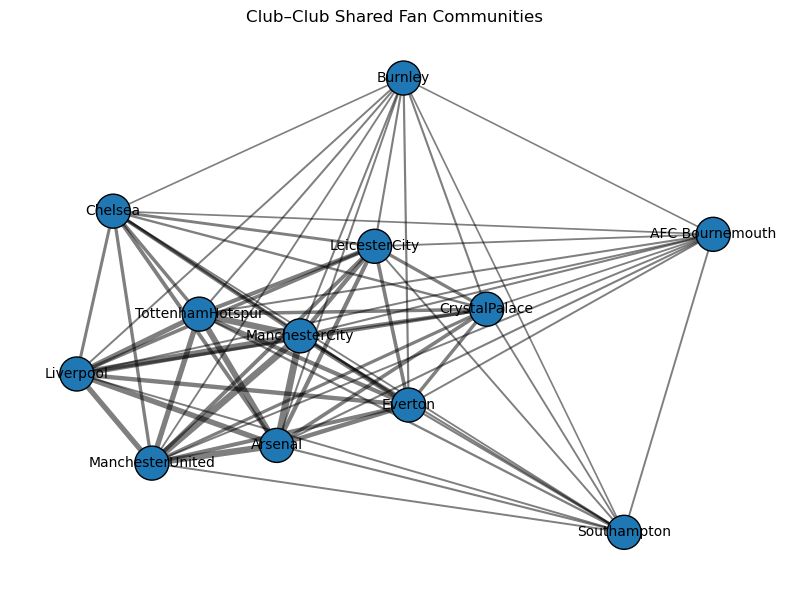

In [40]:

import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
import numpy as np

# Safety check: club_graph must exist
print("Club–club graph:", club_graph.number_of_nodes(), "nodes,", club_graph.number_of_edges(), "edges")

communities = list(community.greedy_modularity_communities(club_graph))

# Map each club -> community id
comm_id = {}
for i, comm in enumerate(communities):
    for node in comm:
        comm_id[node] = i

nx.set_node_attributes(club_graph, comm_id, "community")

print("Number of detected communities:", len(communities))
for i, comm in enumerate(communities):
    print(f"Community {i}: {sorted(comm)}")

# --- 2. Layout & drawing ---
plt.figure(figsize=(8, 6))

# Node positions (use weights to pull strongly connected clubs together)
pos = nx.spring_layout(club_graph, weight='weight', seed=42)

# Colors by community
comms = [club_graph.nodes[n]['community'] for n in club_graph.nodes()]
unique_comms = sorted(set(comms))
color_map = plt.cm.get_cmap('tab10', len(unique_comms))
node_colors = [color_map(c) for c in comms]

# Edge widths proportional to shared fans
edges = club_graph.edges(data=True)
weights = [d['weight'] for (_, _, d) in edges]
# Normalize for plotting
max_w = max(weights) if len(weights) > 0 else 1
edge_widths = [1 + 4*(w / max_w) for w in weights]

nx.draw_networkx_edges(
    club_graph,
    pos,
    width=edge_widths,
    alpha=0.5
)

nx.draw_networkx_nodes(
    club_graph,
    pos,
    node_color=node_colors,
    node_size=600,
    edgecolors='black'
)

nx.draw_networkx_labels(
    club_graph,
    pos,
    font_size=10
)

plt.title("Club–Club Shared Fan Communities")
plt.axis('off')
plt.tight_layout()
plt.show()


## 24. Club Community Detection

We detect clusters of clubs that share many fans using community detection
algorithms on the club-to-club projection network. This reveals natural
groupings in fan allegiances.

In [41]:
# Should already exist from your earlier code
pl_transfers["Date"] = pd.to_datetime(pl_transfers["Date"])
pl_transfers = pl_transfers.dropna(subset=["Date", "To club"])


# Temporal Transfer Impact Analysis

## 25. Transfer Event Impact Analysis

We now analyze how individual transfer events affect fan sentiment in real-time
by examining sentiment changes around specific transfer dates.

In [43]:
transfer_events = (
    pl_transfers[['To club', 'Date', 'Fee_clean_mGBP']]
    .rename(columns={'To club': 'club', 
                     'Fee_clean_mGBP': 'fee_million'})
    .dropna(subset=['club'])
)

transfer_events.head()


,club,Date,fee_million
115,Brighton & Hove Albion,2020-07-27,0.0
116,Zenit Saint Petersburg,2020-07-27,10.9
121,Queens Park Rangers,2020-07-27,0.0
123,Sheffield Wednesday,2020-07-28,0.0
136,Norwich City,2020-07-30,0.0


In [68]:
print("Player" in pl_transfers.columns)


False


In [45]:
window = 3  # days around transfer

event_impact = []

for _, row in transfer_events.iterrows():
    club = row['club']
    date = row['Date']
    fee  = row['fee_million']
    
    low = date - pd.Timedelta(days=window)
    high = date + pd.Timedelta(days=window)
    
    subset = df[(df['club'] == club) &
                (df['date'] >= low) &
                (df['date'] <= high)]
    
    if len(subset) > 0:
        avg_sent = subset['sentiment_ml'].mean()   # using your ML sentiment
        event_impact.append([club, date, fee, avg_sent])

event_df = pd.DataFrame(event_impact, 
                        columns=['club','date','fee_million','avg_sentiment_window'])
event_df.head()


,club,date,fee_million,avg_sentiment_window
0,Liverpool,2020-08-10,11.75,0.838228
1,Southampton,2020-08-11,12.00,0.814432
2,Southampton,2020-08-12,10.90,0.812416
3,Burnley,2020-08-14,0.00,0.823701
4,Arsenal,2020-08-14,0.00,0.762653


In [46]:


# 1) Ensure we only keep actual money transfers (fee > 0)
spend_events = (
    pl_transfers[pl_transfers["Fee_clean_mGBP"] > 0][["Date", "To club", "Fee", "Fee_clean_mGBP"]]
    .rename(columns={
        "To club": "club",
        "Fee_clean_mGBP": "fee_million"
    })
    .sort_values(["club", "Date"])
    .reset_index(drop=True)
)

print("All spending events (raw):")
display(spend_events.head(10))
print(f"Total spending events: {len(spend_events)}")

# 2) Add a pure "day" column for easier joining with tweet data
spend_events["day"] = spend_events["Date"].dt.date

# 3) Build daily sentiment per club (from your tweet dataframe df)
df["day"] = df["date"].dt.date

group_cols = ["club", "day"]

agg_dict = {
    "text": "count",
    "sentiment": "mean",      # VADER (dataset sentiment)
}

# If your self-made sentiment exists, include it too
if "sentiment_ml" in df.columns:
    agg_dict["sentiment_ml"] = "mean"

daily_club_sent = (
    df.groupby(group_cols)
      .agg(agg_dict)
      .rename(columns={
          "text": "tweets_on_day",
          "sentiment": "avg_sentiment_vader",
          "sentiment_ml": "avg_sentiment_ml" if "sentiment_ml" in df.columns else "avg_sentiment_ml"
      })
      .reset_index()
)

print("\nDaily club sentiment (example rows):")
display(daily_club_sent.head(10))

# 4) Merge: for every spending event, attach tweet activity & sentiment on that day
spend_with_sentiment = spend_events.merge(
    daily_club_sent,
    on=["club", "day"],
    how="left"
)

print("\nSpending events with same-day sentiment:")
display(spend_with_sentiment.head(20))

# 5) Example: see all spending events for a specific club (e.g. Arsenal)
example_club = "Arsenal"
print(f"\nAll spending events for {example_club}:")
display(
    spend_with_sentiment[spend_with_sentiment["club"] == example_club]
    .sort_values("Date")
)


All spending events (raw):


,Date,club,Fee,fee_million
0,2020-09-01,Arsenal,£27m[337],27.0
1,2020-09-01,Atalanta,£13.4m[340],13.4
2,2020-08-26,Chelsea,£45m[294],45.0
3,2020-09-04,Chelsea,£71m[365],71.0
4,2020-08-28,Crystal Palace,£19.5m[308],19.5
5,2020-09-05,Everton,£21.7m[375],21.7
6,2020-09-07,Everton,£12m[393],12.0
7,2020-09-08,Everton,£20m[395],20.0
8,2020-09-01,Juventus,£9.5m[332],9.5
9,2020-09-03,Leicester City,£25m[350],25.0


Total spending events: 18

Daily club sentiment (example rows):


,club,day,tweets_on_day,avg_sentiment_vader,avg_sentiment_ml
0,AFC Bournemouth,2020-07-27,266,0.231716,0.770287
1,AFC Bournemouth,2020-07-28,227,0.160952,0.738886
2,AFC Bournemouth,2020-07-29,194,0.257535,0.814935
3,AFC Bournemouth,2020-07-30,585,0.362772,0.932917
4,AFC Bournemouth,2020-07-31,264,0.124462,0.720659
5,AFC Bournemouth,2020-08-01,267,0.229310,0.783964
6,AFC Bournemouth,2020-08-02,203,0.245039,0.794264
7,AFC Bournemouth,2020-08-03,160,0.189662,0.802737
8,AFC Bournemouth,2020-08-04,161,0.147078,0.760998
9,AFC Bournemouth,2020-08-05,261,0.256477,0.840806



Spending events with same-day sentiment:


,Date,club,Fee,fee_million,day,tweets_on_day,avg_sentiment_vader,avg_sentiment_ml
0,2020-09-01,Arsenal,£27m[337],27.00,2020-09-01,1661.0,0.292574,0.833728
1,2020-09-01,Atalanta,£13.4m[340],13.40,2020-09-01,NaN,NaN,NaN
2,2020-08-26,Chelsea,£45m[294],45.00,2020-08-26,591.0,0.237564,0.817323
3,2020-09-04,Chelsea,£71m[365],71.00,2020-09-04,910.0,0.244689,0.827813
4,2020-08-28,Crystal Palace,£19.5m[308],19.50,2020-08-28,NaN,NaN,NaN
5,2020-09-05,Everton,£21.7m[375],21.70,2020-09-05,1107.0,0.238800,0.809964
6,2020-09-07,Everton,£12m[393],12.00,2020-09-07,1262.0,0.240601,0.795621
7,2020-09-08,Everton,£20m[395],20.00,2020-09-08,1496.0,0.251083,0.808571
8,2020-09-01,Juventus,£9.5m[332],9.50,2020-09-01,NaN,NaN,NaN
9,2020-09-03,Leicester City,£25m[350],25.00,2020-09-03,NaN,NaN,NaN



All spending events for Arsenal:


,Date,club,Fee,fee_million,day,tweets_on_day,avg_sentiment_vader,avg_sentiment_ml
0,2020-09-01,Arsenal,£27m[337],27.0,2020-09-01,1661.0,0.292574,0.833728


In [47]:
# ===============================================
# Full table: Every day each PL club spent money
# ===============================================

# Your PL club list
pl_clubs = {
    "Arsenal",
    "Manchester United",
    "Liverpool",
    "Manchester City",
    "Tottenham Hotspur",
    "Everton",
    "Chelsea",
    "Crystal Palace",
    "Leicester City",
    "Southampton",
    "Burnley",
}

# Optional: check what columns we actually have
print(pl_transfers.columns)

# Filter to:
# - rows where the buyer is a PL club (To club)
# - fee_clean_mGBP > 0 (actual money spent, not loans/free/etc.)
club_spending_table = (
    pl_transfers[
        (pl_transfers["To club"].isin(pl_clubs)) &
        (pl_transfers["Fee_clean_mGBP"] > 0)
    ][["Date", "To club", "Fee", "Fee_clean_mGBP"]]  # <-- no 'Player' here
    .rename(columns={
        "To club": "club",
        "Fee_clean_mGBP": "fee_million"
    })
    .sort_values(["club", "Date"])
    .reset_index(drop=True)
)

print(f"Total spending events: {len(club_spending_table)}")
display(club_spending_table)


Index(['Date', 'From club', 'To club', 'Fee', 'Fee_clean_mGBP'], dtype='object')
Total spending events: 15


,Date,club,Fee,fee_million
0,2020-09-01,Arsenal,£27m[337],27.00
1,2020-08-26,Chelsea,£45m[294],45.00
2,2020-09-04,Chelsea,£71m[365],71.00
3,2020-08-28,Crystal Palace,£19.5m[308],19.50
4,2020-09-05,Everton,£21.7m[375],21.70
5,2020-09-07,Everton,£12m[393],12.00
6,2020-09-08,Everton,£20m[395],20.00
7,2020-09-03,Leicester City,£25m[350],25.00
8,2020-08-10,Liverpool,£11.75m[203],11.75
9,2020-08-04,Manchester City,£20.87m[172],20.87


In [48]:
df['datetime'] = pd.to_datetime(df['date'])
df['hour'] = df['datetime'].dt.floor('H')


/var/folders/xc/9wtnldyd2rlc_nnrrrzqqqn40000gn/T/ipykernel_62166/4140647574.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['hour'] = df['datetime'].dt.floor('H')


In [49]:
transfer_events = club_spending_table.copy()
transfer_events['Date'] = pd.to_datetime(transfer_events['Date'])
transfer_events = transfer_events.sort_values(['club', 'Date']).reset_index(drop=True)

display(transfer_events.head())


,Date,club,Fee,fee_million
0,2020-09-01,Arsenal,£27m[337],27.0
1,2020-08-26,Chelsea,£45m[294],45.0
2,2020-09-04,Chelsea,£71m[365],71.0
3,2020-08-28,Crystal Palace,£19.5m[308],19.5
4,2020-09-05,Everton,£21.7m[375],21.7


In [50]:
from datetime import timedelta

window_hours = 48
all_windows = []

for _, row in transfer_events.iterrows():
    club = row['club']
    t0 = row['Date']  # transfer date
    
    start = t0 - timedelta(hours=window_hours)
    end   = t0 + timedelta(hours=window_hours)
    
    # Filter tweets for that club in the window
    subset = df[
        (df['club'] == club) &
        (df['datetime'] >= start) &
        (df['datetime'] <= end)
    ].copy()
    
    if len(subset) == 0:
        continue
    
    # Compute hours relative to transfer
    subset['hours_from_event'] = (subset['datetime'] - t0).dt.total_seconds() / 3600
    
    # Aggregate to hourly average sentiment
    hourly = subset.groupby('hours_from_event')['sentiment'].mean().reset_index()
    hourly['club'] = club
    
    all_windows.append(hourly)

event_windows = pd.concat(all_windows, ignore_index=True)
display(event_windows.head())


,hours_from_event,sentiment,club
0,-46.483889,0.6369,Arsenal
1,-46.471944,-0.2732,Arsenal
2,-46.445833,0.8176,Arsenal
3,-46.429722,0.0000,Arsenal
4,-46.417778,0.0000,Arsenal


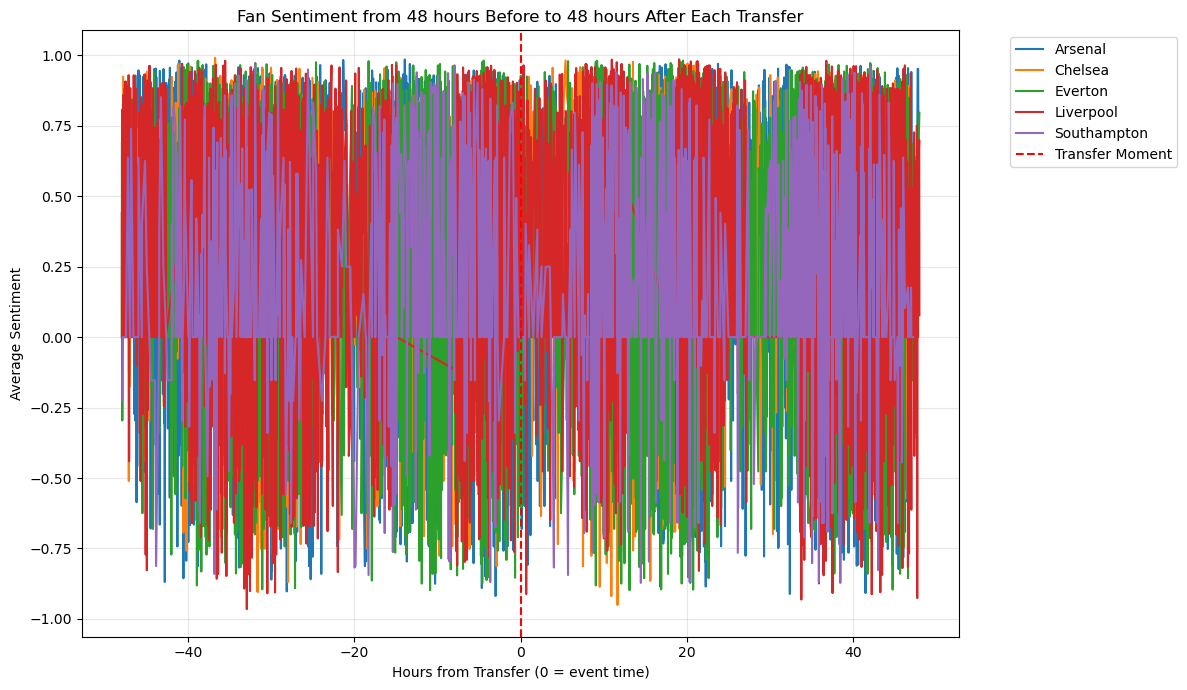

In [51]:
plt.figure(figsize=(12,7))

clubs_list = event_windows['club'].unique()

for club in clubs_list:
    sub = event_windows[event_windows['club'] == club]
    sub = sub.sort_values('hours_from_event')
    plt.plot(sub['hours_from_event'], sub['sentiment'], label=club)

plt.axvline(0, color='red', linestyle='--', label='Transfer Moment')

plt.xlabel("Hours from Transfer (0 = event time)")
plt.ylabel("Average Sentiment")
plt.title("Fan Sentiment from 48 hours Before to 48 hours After Each Transfer")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Build table of transfer "events" (PL clubs as buyers, fee > 0) ---
event_clubs = pl_clubs  # the same set you used before

transfer_events = (
    pl_transfers[
        (pl_transfers["To club"].isin(event_clubs)) &
        (pl_transfers["Fee_clean_mGBP"] > 0)
    ][["Date", "To club", "Fee_clean_mGBP"]]
    .rename(columns={"To club": "club", "Fee_clean_mGBP": "fee_million"})
    .dropna(subset=["Date", "club"])
    .reset_index(drop=True)
)

print("Number of spending events:", len(transfer_events))
transfer_events.head()


Number of spending events: 15


,Date,club,fee_million
0,2020-08-04,Manchester City,20.87
1,2020-08-05,Manchester City,41.00
2,2020-08-10,Liverpool,11.75
3,2020-08-11,Tottenham Hotspur,15.00
4,2020-08-11,Southampton,12.00


## 26. 48-Hour Transfer Window Analysis (VADER Sentiment)

We analyze sentiment changes in a 48-hour window around each transfer event
using the original VADER sentiment scores to capture immediate fan reactions.

In [53]:
# --- 2. Build tweet windows (-48h .. +48h) around each transfer event ---

# Make sure tweet times are datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])

window_hours = 48
records = []

for _, ev in transfer_events.iterrows():
    club = ev["club"]
    t0   = ev["Date"]  # event date (already datetime)

    t_start = t0 - pd.Timedelta(hours=window_hours)
    t_end   = t0 + pd.Timedelta(hours=window_hours)

    # Tweets mentioning this club in the window
    tweets = df[
        (df["club"] == club) &
        (df["date"] >= t_start) &
        (df["date"] <= t_end)
    ].copy()

    if tweets.empty:
        continue

    # Relative hour from event time (round DOWN to nearest hour)
    delta = tweets["date"] - t0
    tweets["rel_hour"] = (delta.dt.total_seconds() // 3600).astype(int)

    # Keep only the bits we need
    tweets = tweets[["club", "rel_hour", "sentiment"]]
    records.append(tweets)

# Concatenate all event windows
transfer_windows_df = pd.concat(records, ignore_index=True)
print("Total tweets in transfer windows:", len(transfer_windows_df))
transfer_windows_df.head()


Total tweets in transfer windows: 30509


,club,rel_hour,sentiment
0,Liverpool,-15,0.0000
1,Liverpool,-15,-0.4767
2,Liverpool,-15,0.8461
3,Liverpool,-15,-0.4951
4,Liverpool,-15,0.0000


In [54]:
# --- 3. Average sentiment per club & relative hour ---

hourly_avg = (
    transfer_windows_df
    .groupby(["club", "rel_hour"])["sentiment"]
    .mean()
    .reset_index()
)

# Restrict to -48 .. +48 hours (should already be true, but just in case)
hourly_avg = hourly_avg[hourly_avg["rel_hour"].between(-window_hours, window_hours)]

hourly_avg.head()


,club,rel_hour,sentiment
0,Arsenal,-47,0.325489
1,Arsenal,-46,0.358598
2,Arsenal,-45,0.377647
3,Arsenal,-44,0.330161
4,Arsenal,-43,0.391491


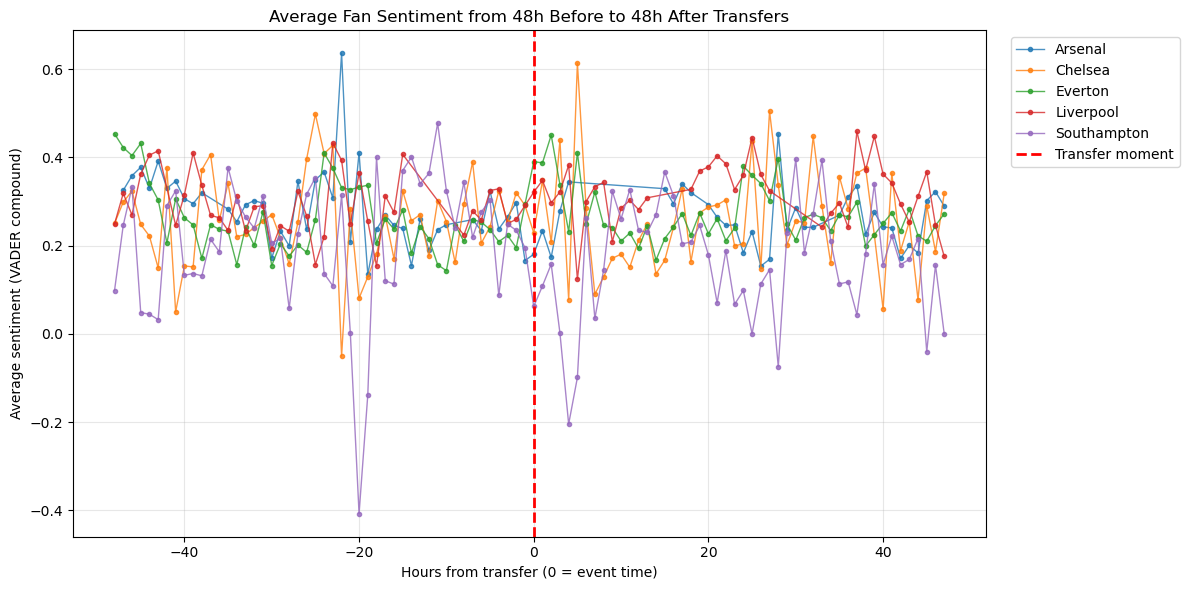

In [55]:
# --- 4. Plot: average sentiment from -48h to +48h for each club ---

plt.figure(figsize=(12, 6))

# choose which clubs to plot (all, or a subset)
clubs_to_plot = sorted(hourly_avg["club"].unique())
# e.g. to limit:
# clubs_to_plot = ["Arsenal", "Chelsea", "Everton", "Liverpool", "Southampton"]

for club in clubs_to_plot:
    sub = hourly_avg[hourly_avg["club"] == club].sort_values("rel_hour")
    plt.plot(sub["rel_hour"], sub["sentiment"], marker=".", linewidth=1, alpha=0.8, label=club)

# Vertical line at event time (0 hours)
plt.axvline(0, color="red", linestyle="--", linewidth=2, label="Transfer moment")

plt.xlabel("Hours from transfer (0 = event time)")
plt.ylabel("Average sentiment (VADER compound)")
plt.title("Average Fan Sentiment from 48h Before to 48h After Transfers")
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [56]:
# Ensure ML sentiment exists (from your earlier steps)
assert "sentiment_ml" in df.columns, "You must compute sentiment_ml before running this."

# Premier League clubs used in your dataset
pl_clubs = {
    "Arsenal", "Manchester United", "Liverpool", "Manchester City",
    "Tottenham Hotspur", "Everton", "Chelsea", "Crystal Palace",
    "Leicester City", "Southampton", "Burnley"
}

# Extract transfer events
transfer_events = (
    pl_transfers[
        (pl_transfers["To club"].isin(pl_clubs)) &
        (pl_transfers["Fee_clean_mGBP"] > 0)
    ][["Date", "To club", "Fee_clean_mGBP"]]
    .rename(columns={"To club": "club", "Fee_clean_mGBP": "fee_million"})
    .dropna(subset=["Date", "club"])
    .reset_index(drop=True)
)

print("Number of transfer events:", len(transfer_events))
transfer_events.head()


Number of transfer events: 15


,Date,club,fee_million
0,2020-08-04,Manchester City,20.87
1,2020-08-05,Manchester City,41.00
2,2020-08-10,Liverpool,11.75
3,2020-08-11,Tottenham Hotspur,15.00
4,2020-08-11,Southampton,12.00


## 27. 24-Hour Transfer Window Analysis (ML Sentiment)

We repeat the transfer impact analysis using our self-made ML sentiment model
to see if different sentiment measures capture different aspects of fan reactions.

In [57]:
# Make sure timestamps are correct
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"])

window_hours = 24
records_ml = []

for _, ev in transfer_events.iterrows():
    club = ev["club"]
    t0 = ev["Date"]

    t_start = t0 - pd.Timedelta(hours=window_hours)
    t_end = t0 + pd.Timedelta(hours=window_hours)

    tweets = df[
        (df["club"] == club) &
        (df["date"] >= t_start) &
        (df["date"] <= t_end)
    ].copy()

    if tweets.empty:
        continue

    # Relative time in hours
    delta = tweets["date"] - t0
    tweets["rel_hour"] = (delta.dt.total_seconds() // 3600).astype(int)

    # Keep ML sentiment
    tweets = tweets[["club", "rel_hour", "sentiment_ml"]]

    records_ml.append(tweets)

transfer_windows_ml = pd.concat(records_ml, ignore_index=True)

print("Tweets in ML sentiment windows:", len(transfer_windows_ml))
transfer_windows_ml.head()


Tweets in ML sentiment windows: 16099


,club,rel_hour,sentiment_ml
0,Liverpool,-15,0.651669
1,Liverpool,-15,0.534444
2,Liverpool,-15,0.997330
3,Liverpool,-15,0.031439
4,Liverpool,-15,0.951712


In [58]:
hourly_avg_ml = (
    transfer_windows_ml
    .groupby(["club", "rel_hour"])["sentiment_ml"]
    .mean()
    .reset_index()
)

hourly_avg_ml = hourly_avg_ml[
    hourly_avg_ml["rel_hour"].between(-window_hours, window_hours)
]

hourly_avg_ml.head()


,club,rel_hour,sentiment_ml
0,Arsenal,-24,0.829525
1,Arsenal,-23,0.769210
2,Arsenal,-22,0.955467
3,Arsenal,-21,0.801464
4,Arsenal,-20,0.872556


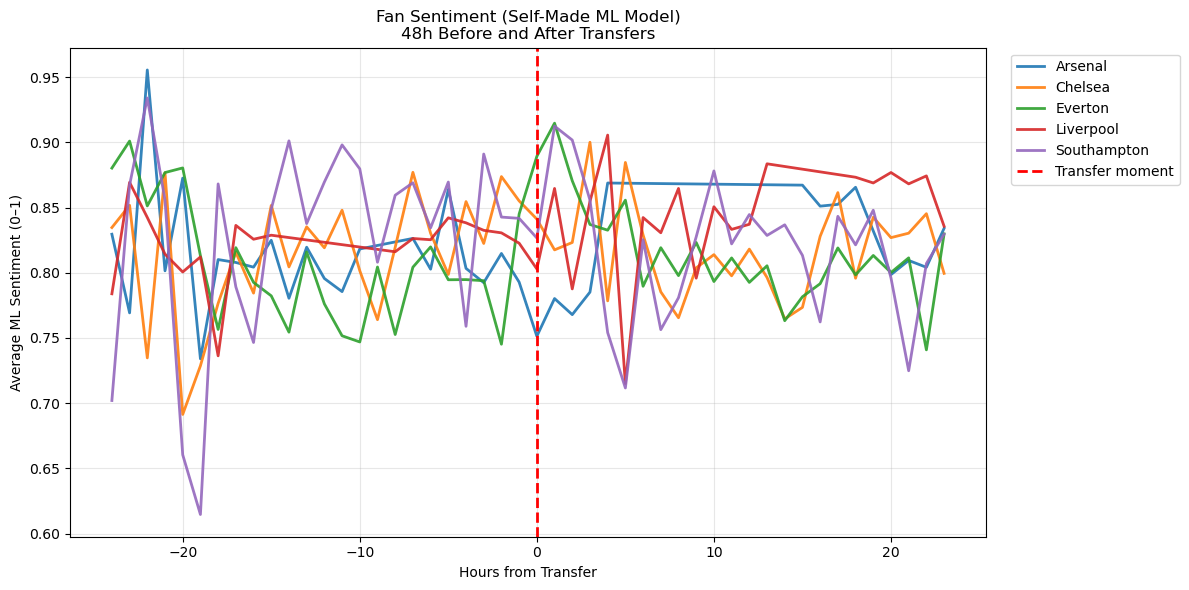

In [59]:
plt.figure(figsize=(12, 6))

clubs_to_plot = sorted(hourly_avg_ml["club"].unique())

for club in clubs_to_plot:
    sub = hourly_avg_ml[hourly_avg_ml["club"] == club].sort_values("rel_hour")
    plt.plot(
        sub["rel_hour"], 
        sub["sentiment_ml"], 
        linewidth=2,
        alpha=0.9,
        label=club
    )

# Transfer moment at hour 0
plt.axvline(0, color="red", linestyle="--", linewidth=2, label="Transfer moment")

plt.title("Fan Sentiment (Self-Made ML Model)\n48h Before and After Transfers")
plt.xlabel("Hours from Transfer")
plt.ylabel("Average ML Sentiment (0–1)")
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


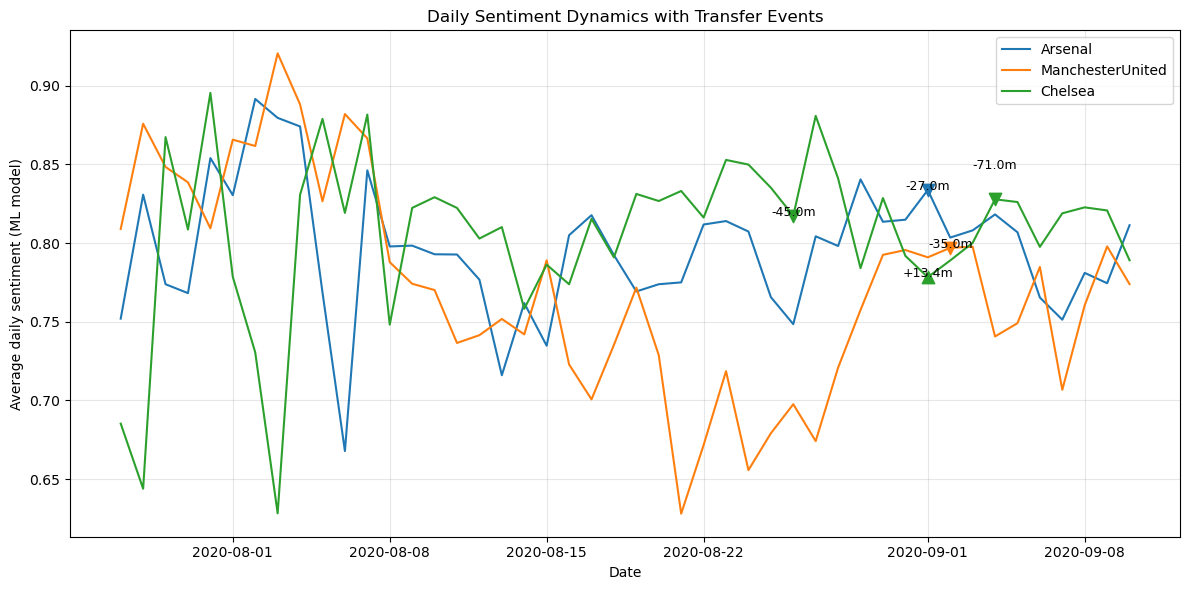

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# SETUP
# ----------------------------------------------------------
tweets = df.copy()
transfers = pl_transfers.copy()

clubs_to_plot = ["Arsenal", "ManchesterUnited", "Chelsea"]

# Map Wikipedia names to your dataset's names
name_map = {
    "Arsenal": "Arsenal",
    "Manchester United": "ManchesterUnited",
    "Chelsea": "Chelsea",
    "Liverpool": "Liverpool",
    "Everton": "Everton",
    "Manchester City": "ManchesterCity",
    "Tottenham Hotspur": "TottenhamHotspur",
    "Leicester City": "LeicesterCity",
    "Burnley": "Burnley",
    "Southampton": "Southampton",
    "Crystal Palace": "CrystalPalace",
    "AFC Bournemouth": "AFCBournemouth",
}

# Line colours
color_map = {
    "Arsenal": "tab:blue",
    "ManchesterUnited": "tab:orange",
    "Chelsea": "tab:green",
}

# ----------------------------------------------------------
# CLEAN DATA
# ----------------------------------------------------------
tweets["date"] = pd.to_datetime(tweets["date"], errors="coerce")
transfers["Date"] = pd.to_datetime(transfers["Date"], errors="coerce").dt.date

daily_sentiment = (
    tweets[tweets["club"].isin(clubs_to_plot)]
    .groupby(["club", tweets["date"].dt.date])["sentiment_ml"]
    .mean()
    .reset_index()
    .rename(columns={"date": "day", "sentiment_ml": "avg_sentiment"})
)

# ----------------------------------------------------------
# BUILD EVENT TABLE WITH SIGN CONVENTION (SPEND = NEGATIVE)
# ----------------------------------------------------------
event_rows = []
for _, row in transfers.iterrows():
    fee = float(row["Fee_clean_mGBP"]) if pd.notna(row["Fee_clean_mGBP"]) else 0.0
    from_c = name_map.get(row["From club"], row["From club"])
    to_c   = name_map.get(row["To club"], row["To club"])
    d      = row["Date"]

    # Spending money → negative
    if to_c in clubs_to_plot:
        event_rows.append({"club": to_c, "date": d, "fee_m": -fee, "direction": "in"})
    # Receiving money → positive
    if from_c in clubs_to_plot:
        event_rows.append({"club": from_c, "date": d, "fee_m": +fee, "direction": "out"})

events = pd.DataFrame(event_rows)
events = events[events["fee_m"].abs() >= 5]   # avoid clutter

# ----------------------------------------------------------
# HELPER: AUTO-SPACING OF LABELS TO AVOID OVERLAP
# ----------------------------------------------------------
def get_non_overlapping_y(base_y, existing_positions, min_sep=0.015):
    """
    Shift label vertically until it doesn't overlap with existing ones.
    """
    y = base_y
    for _ in range(20):  # max 20 attempts
        if all(abs(y - e) > min_sep for e in existing_positions):
            return y
        y += min_sep * 1.3  # shift upward
    return y

# ----------------------------------------------------------
# PLOT
# ----------------------------------------------------------
plt.figure(figsize=(12, 6))
marker_styles = {"in": "v", "out": "^"}  # ▼ spending, ▲ earning

for club in clubs_to_plot:
    series = daily_sentiment[daily_sentiment["club"] == club]
    color = color_map[club]

    plt.plot(series["day"], series["avg_sentiment"], label=club, color=color)

    club_events = events[events["club"] == club]
    used_y_positions = []  # store y-values already used for labels

    for _, e in club_events.iterrows():
        x = e["date"]
        vals = series[series["day"] == x]["avg_sentiment"]
        if vals.empty:
            continue
        base_y = vals.iloc[0]

        # Compute y placement with collision avoidance
        y_text = get_non_overlapping_y(base_y, used_y_positions)
        used_y_positions.append(y_text)

        m = marker_styles[e["direction"]]

        # Plot marker
        plt.scatter(x, base_y, s=80, marker=m, color=color, zorder=4)

        # Label (in black)
        label = f"{e['fee_m']:+.1f}m"
        plt.text(
            x, y_text,
            label,
            fontsize=9,
            ha="center",
            color="black",
            zorder=5,
        )

plt.xlabel("Date")
plt.ylabel("Average daily sentiment (ML model)")
plt.title("Daily Sentiment Dynamics with Transfer Events")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("time_series_sentiment_transfers.png", dpi=300)
plt.show()


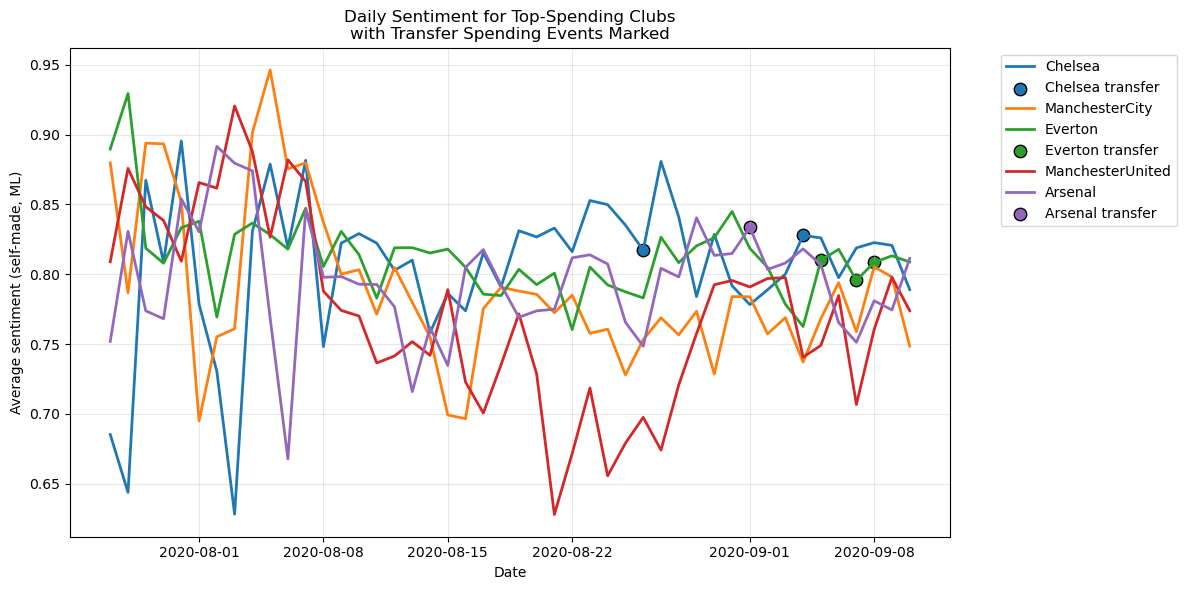

In [73]:
# Extract spending events (fee > 0)
spending_events = pl_transfers[
    (pl_transfers["Fee_clean_mGBP"] > 0) &
    (pl_transfers["To club"].isin(top_spenders))
][["To club", "Date", "Fee_clean_mGBP"]].rename(columns={"To club": "club"})
spending_events["day"] = spending_events["Date"].dt.date

plt.figure(figsize=(12, 6))

for club_name in top_spenders:
    # Plot sentiment line
    sub = daily_sent_ml[daily_sent_ml['club'] == club_name]
    plt.plot(sub['day'], sub['sentiment_ml'], label=club_name, linewidth=2)
    
    # Get spending events for this club
    se = spending_events[spending_events["club"] == club_name]
    
    # Plot each spending event as a scatter point
    plt.scatter(
        se["day"],
        sub.set_index("day").loc[se["day"], "sentiment_ml"],
        s=80,
        marker="o",
        edgecolor="black",
        linewidth=1,
        label=f"{club_name} transfer" if len(se) > 0 else None
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Date")
plt.ylabel("Average sentiment (self-made, ML)")
plt.title("Daily Sentiment for Top-Spending Clubs\nwith Transfer Spending Events Marked")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


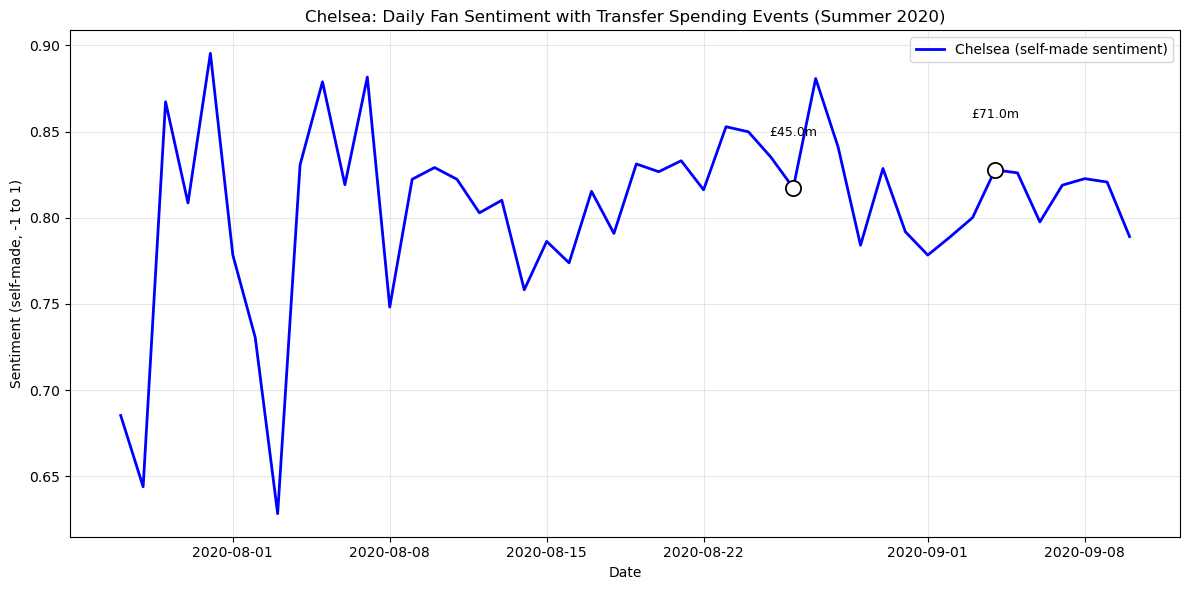

In [74]:
import matplotlib.pyplot as plt
import re

# --- Canonical key for matching club names ---
def canon(s):
    return re.sub(r'[^a-z0-9]+', '', str(s).lower())

chelsea_key = canon("Chelsea")

# --- Prepare daily sentiment with canonical key ---
daily_sent_ml = daily_sent_ml.copy()
daily_sent_ml['club_key'] = daily_sent_ml['club'].apply(canon)

# --- Prepare transfer table ---
pl_transfers = pl_transfers.copy()
pl_transfers['Date'] = pd.to_datetime(pl_transfers['Date'], errors='coerce')

# Only incoming transfers (spending)
spending_events = pl_transfers[
    (pl_transfers["Fee_clean_mGBP"] > 0) &
    (pl_transfers["To club"].apply(canon) == chelsea_key)
].copy()

# Day column for alignment
spending_events['day'] = spending_events['Date'].dt.date

# --- Chelsea daily sentiment ---
chelsea_sent = daily_sent_ml[daily_sent_ml['club_key'] == chelsea_key].sort_values("day")

plt.figure(figsize=(12,6))

# Plot sentiment line
plt.plot(
    chelsea_sent['day'],
    chelsea_sent['sentiment_ml'],
    label="Chelsea (self-made sentiment)",
    linewidth=2,
    color="blue"
)

# --- Plot transfer markers ---
for _, row in spending_events.iterrows():
    d = row['day']
    fee = row['Fee_clean_mGBP']  # already numeric (million GBP)

    # Find sentiment on this exact date, if exists
    mask = chelsea_sent['day'] == d
    if not mask.any():
        continue

    y_val = chelsea_sent.loc[mask, 'sentiment_ml'].mean()

    # Dot on the line
    plt.scatter(
        d, y_val,
        s=120,
        marker='o',
        edgecolor='black',
        facecolor='white',
        linewidth=1.3,
        zorder=5
    )

    # Fee label next to the dot
    plt.text(
        d, y_val + 0.03,
        f"£{fee:.1f}m",
        fontsize=9,
        ha='center'
    )

# --- Plot aesthetics ---
plt.xlabel("Date")
plt.ylabel("Sentiment (self-made, -1 to 1)")
plt.title("Chelsea: Daily Fan Sentiment with Transfer Spending Events (Summer 2020)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## 28. Case Study: Chelsea Transfer Activity

We focus on Chelsea as a detailed case study, visualizing their daily sentiment
alongside their specific transfer events to show how spending affects fan mood.

In [75]:
# Clean transfer table
pl_transfers['Date'] = pd.to_datetime(pl_transfers['Date'], errors='coerce')
transfer_events = pl_transfers[pl_transfers['Fee_clean_mGBP'] > 0].copy()

transfer_events['transfer_day'] = transfer_events['Date'].dt.date
transfer_events['club'] = transfer_events['To club']


In [76]:
import re

def get_transfer_day_reactions(df_tweets, transfers_df, club_name, top_n=5):
    """
    df_tweets : tweet dataframe (must have columns: 'date', club column, 'sentiment_ml_scaled', 'user', 'text', 'retweets')
    transfers_df : transfer table (pl_transfers; must have Date, Fee_clean_mGBP, and club info)
    club_name : e.g. "Chelsea"
    top_n : number of positive/negative tweets to show
    """

    # --- 0. Utility: canonical key for matching club names ---
    def canon(s):
        return re.sub(r'[^a-z0-9]+', '', str(s).lower())

    # --- 1. Detect tweet club column ---
    if 'club' in df_tweets.columns:
        tweet_club_col = 'club'
    elif 'file_name' in df_tweets.columns:
        tweet_club_col = 'file_name'
    else:
        raise KeyError("Could not find a club column in tweet df (expected 'club' or 'file_name').")

    # Make sure tweet dates are datetime
    if not np.issubdtype(df_tweets['date'].dtype, np.datetime64):
        df_tweets['date'] = pd.to_datetime(df_tweets['date'], errors='coerce')

    # --- 2. Prepare transfers table ---
    tdf = transfers_df.copy()
    if 'Date' not in tdf.columns:
        raise KeyError("Transfers DF must have a 'Date' column.")

    tdf['Date'] = pd.to_datetime(tdf['Date'], errors='coerce')

    # spending events only
    if 'Fee_clean_mGBP' not in tdf.columns:
        raise KeyError("Transfers DF must have 'Fee_clean_mGBP' (parsed fee).")

    tdf = tdf[tdf['Fee_clean_mGBP'] > 0].copy()
    tdf['transfer_day'] = tdf['Date'].dt.date

    # detect which column holds the BUYING club
    if 'club' in tdf.columns:
        transfer_club_col = 'club'
    elif 'To club' in tdf.columns:
        transfer_club_col = 'To club'
    else:
        raise KeyError("Transfers DF must have 'club' or 'To club' for the buying club.")

    # canonical keys
    tdf['club_key'] = tdf[transfer_club_col].apply(canon)
    tweets = df_tweets.copy()
    tweets['club_key'] = tweets[tweet_club_col].apply(canon)

    target_key = canon(club_name)

    club_transfers = tdf[tdf['club_key'] == target_key]

    if club_transfers.empty:
        print(f"⚠ No spending transfers found for {club_name}.")
        return None

    results = {}

    for _, row in club_transfers.iterrows():
        tday = row['transfer_day']

        # tweets for this club on that day
        mask = (tweets['club_key'] == target_key) & (tweets['date'].dt.date == tday)
        day_tweets = tweets[mask]

        if day_tweets.empty:
            continue

        # sort by self-made sentiment (scaled –1..1)
        best = day_tweets.sort_values('sentiment_ml_scaled', ascending=False).head(top_n)
        worst = day_tweets.sort_values('sentiment_ml_scaled', ascending=True).head(top_n)

        # get some transfer info if present
        transfer_info_cols = [c for c in ['Player', 'Fee', 'Fee_clean_mGBP'] if c in row.index]
        transfer_info = row[transfer_info_cols] if transfer_info_cols else None

        results[tday] = {
            'transfer_info': transfer_info,
            'best': best[['user', 'text', 'sentiment_ml_scaled', 'retweets']],
            'worst': worst[['user', 'text', 'sentiment_ml_scaled', 'retweets']]
        }

    if not results:
        print(f"No tweets found on exact transfer days for {club_name}.")
    return results


## 29. Transfer Day Reaction Analysis

We examine specific tweets from transfer days to understand what fans were
actually saying when their clubs made signings. This provides qualitative
insight into the quantitative sentiment patterns we've observed.

In [77]:
chelsea_reactions = get_transfer_day_reactions(df, pl_transfers, "Chelsea", top_n=10)


In [78]:
for day, info in chelsea_reactions.items():
    print("\n" + "="*40)
    print(f"Transfer Day: {day}")
    if info['transfer_info'] is not None:
        print("Transfer info:")
        display(info['transfer_info'].to_frame().T)
    
    print("\n🔵 Top 5 Most Positive Tweets:")
    display(info['best'])
    
    print("\n🔴 Top 5 Most Negative Tweets:")
    display(info['worst'])



Transfer Day: 2020-08-26
Transfer info:


,Fee,Fee_clean_mGBP
322,£45m[294],45.0



🔵 Top 5 Most Positive Tweets:


,user,text,sentiment_ml_scaled,retweets
549896,RJ,"Wishing my son Sebastian a very happy 5th birthday 🙂 As passionate 🔵s fans, we would love to celebrate this special occasion with some big announcements! 🙏 P.s. a signed 2020-21 jersey would also be greatly appreciated 😉 (come on @ChelseaFC, make it happen!) #Chelsea #CFC https://t.co/misDnKk4lp",0.998687,108
550024,Honest Abe,"Being a chelsea fan is great, best decision of my life. #CFC #ChelseaFC",0.996151,0
550111,$∆/,Welcome to Chelsea @BenChilwell I am really happy that we have backed Frank on this &amp; made this move.. Super excited to see how this gets on...💙💙 #CFC #ChelseaFC @ChelseaFC https://t.co/o2LciR6qMs,0.994177,0
550299,CFC_4R,"✍️ l “We are very pleased to have completed our third addition to our exciting squad for the coming season. Ben brings plenty of top-level experience playing in the Premier League, Champions League and at international level, despite his young age.” - Marina. #cfc #Chelsea",0.994032,0
550043,Hedley On Chelsea FC 🦁,Welcome to @ChelseaFC Good luck @BenChilwell - Excited to have you here! Think you’re just what we need going forward! 💙 #PrideOfLondon #CFC #ChelseaFC #ChillyB #Chilwell https://t.co/OEz7e0Wfr4,0.993645,0
549967,jordanxcollins,I think this graphic says everything we need to know about #Chilwell. I wish him the best at the club and am excited to see him get to work. #CFC #Chelseafc https://t.co/aWLVhj1dsl,0.992608,2
550261,Wini_con🔗🇳🇬💯,BEST SUMMER FOR ME SINCE 2014 #CFC #Chelsea welcome @BenChilwell to the family 💙💙💙💙🚨 https://t.co/hq9Mx5lDlC,0.992374,0
550052,IG: mryinka123,Hopefully Thiago Silva and Kai Havertz announcements will follow soon. What a great time to be a Chelsea fan #Chelsea #ChelseaFC #CFC,0.991053,0
549928,Angelo Mangiante,"Tomorrow medicals and signing for #ThiagoSilva. Two years contract, €6M/season as wage. High quality for #CFC defense. He wants to play 3-4 years more and be part of the Brazil Team in Qatar World Cup. Great player and great leader for Lampard. @SkySport #Chelsea #Transfers https://t.co/Acr9OBx29h",0.990728,750
550041,BannedWölfinnenFan,Very nice sight to see Chelsea FC doing business again : ABOUT TIME ! And in quality players this time ! Also some youngsters will keep having their chances ! I'm glad with that ! #ChelseaFC #CFC #UTC ! Let's make Havertz real also ! It would be a great move !,0.990573,0



🔴 Top 5 Most Negative Tweets:


,user,text,sentiment_ml_scaled,retweets
549931,Noah Robson,"This is an awful error on the PGMOL’s part and both the fact he is allowed to referee in games where he is biased AND get away with such awful decisions, particularly against Chelsea, is a disgrace. [END] #anthonytaylor #corrupt #cfc #ChelseaFC",-0.986207,0
549890,Talk Chelsea,Bid for Mendy rejected! ❌ @telefoot_TF1 l #CFC #Chelsea https://t.co/x32LGj39Sx,-0.983285,8
549871,🙍🏻‍♀️🙍🏻‍♀️,Btw - the moment I open Twitter and see announcements from @ChelseaFC on Kai/Thiago/Chilwell is gonna be one hell of a moment holy shit😳😳😍😍 acc cant wait guys!!!!! And all the fellow Chelsea accounts gonna go crazy!😍 gonna be a madness fr #ChelseaFC #cfc #transfers,-0.973837,0
549895,Tommy,The Disrespect our own fans have for Azpi is fucking disgusting #CFC #Chelsea,-0.965268,0
549998,Muskey x,Ffs lads 😂 #Chelsea #CFC,-0.965163,0
549919,My Football Books,"#Recommended Football Book: STAMFORD BRIDGE IS FALLING DOWN by @tim_rolls tells how bad decisions, bad management, bad judgement, bad attitude, bad luck and bad football took #ChelseaFC from European Glory to its knees in four years.⚽️📘#CFC Buy here➡️ https://t.co/ZwXoEbLHPH https://t.co/0kMwjkwsI8",-0.846441,0
550173,Sinful Saint ™🌹,"Oluwa o, Chelsea must not flop 🙏 Ben Chilwell must not Flop 🙏 Thiago Silva must not flop🙏 Kai Havertz must not flop🙏 Hakim Ziyech must not flop🙏 Timo Werner must not flop 🙏 #BenIsBlue #Kai #ChelseaFC #COYB #CFC https://t.co/mnQI0b8zOc",-0.833897,2
549894,Owuraku Obeng 🗯,Utter nonsense !!! Even tier 6 clubs in Azerbaijan 🇦🇿 know #Chelsea is paying €80 million to get Harvertz why delay it? #CFC https://t.co/eGQPG68koP,-0.713761,0
49440,Chad,On this day: 1978 - Police made 41 arrests when fights broke out after a Spurs vs Chelsea game. #CFC #Chelsea,-0.694804,4
549957,John Harrison,In the 2019/2020 #PremierLeague season #Chelsea’s #Kepa did not come &amp; catch a single corner! 🤯🤯🤯 #Kepa did attempt to claim 4 corners: 2 he punched away from danger 1 he punched into danger &amp; 1 he failed to make any contact with the ball &amp; #WestHam scored. #CFC #GKUnion https://t.co/9C9VOe0sGJ,-0.684919,125



Transfer Day: 2020-09-04
Transfer info:


,Fee,Fee_clean_mGBP
402,£71m[365],71.0



🔵 Top 5 Most Positive Tweets:


,user,text,sentiment_ml_scaled,retweets
695829,ChelZeaZ ⚽️ KTBFFH,#JonathanDavid A good friend of mine and a talented player!!! Here with my two boys! Was hoping Jonathan would play for #Chelsea #PremierLeague this season but I support his move to @LOSC_EN Lille - wish him great success in his next step! Future #cfc blue 🙏 one day! 💙🇨🇦 https://t.co/580S90Tygt,0.999846,1
695812,190FIVE,"Happy Birthday to one of our own, @JamieCumming_! We hope @StevenageFC are treating you well! Have the best day and a great season! 🙌🏼💙 #190FIVE #CFC #CHELSEAFC https://t.co/aP7FOI7948",0.999510,2
612147,The Chelsea Spot,"‘I am very happy and proud to be here, For me it is a dream come true to play in a big club like Chelsea and I can’t wait to meet all the players and the trainers. Yeah, I am very happy to be here!’ We are very happy too! 💙 #CFC | #Chelsea | #HiKai https://t.co/LuNmoX20Dt",0.999172,3
609493,Steefler ❼,Welcome @kaihavertz29 i can say @TIGGZVids made the best video for havertz and also chose the best song.. thank you mate🤝🤝🔥 @FabrizioRomano 😂😂💙#havertz #chelsea #CFC https://t.co/BB3It57oDW,0.999126,2
609373,Chelsea UK,"@kaihavertz29 first interview as a #Chelsea player: “It’s a dream come true to play at a club like Chelsea.” “Lampard had a big impact on my decision, I loved him as a player. I can’t wait to learn from him.” “I’ll do my best to make #CFC fans proud, and to bring success.” https://t.co/EFXZgpxy8s",0.999101,1
609375,Obasi_,"Kai Havertz-""It’s a dream come true to play at a club like Chelsea.Lampard had a big impact on my decision, I loved him as a player. I can’t wait to learn from him. I’ll do my best to make Chelsea fans proud, and to bring success.” #CFC #Chelsea #Hikai https://t.co/zLfcfSG5U5",0.998714,0
612146,Blues at Bridge,"@kaihavertz29: ""‘I am very happy and proud to be here, For me it is a dream come true to play in a big club like Chelsea and I can’t wait to meet all the players and the trainers. Yeah, I am very happy to be here!"" [via @ChelseaFC] #HiKai #ChelseaFC #CFC",0.998676,0
609548,Robbos Gobcast,Well then. Looks like Chelsea are now a massive challenge for the league. Wow fair play and what a signing. What a team Chelsea now have and the depth is amazing. #cfc #Chelsea https://t.co/dgWJHWmwuI,0.998539,0
609441,The Blue Flag,"Kai Havertz on joining Chelsea - ""I am very happy and proud to be here, For me it is a dream come true to play in a big club like #Chelsea and I can’t wait to meet all the players and the trainers. Yeah, I am very happy to be here!"" #CFC",0.998499,4
609553,Kolawole Koks,"‘I am very happy and proud to be here, For me it is a dream come true to play in a big club like Chelsea and I can’t wait to meet all the players and the trainers. Yeah, I am very happy to be here!’ #CFC #ChelseaFC #HiKai #havertzisblue And I was exactly spot on 😁👇🏾 https://t.co/uhHESw2bh9",0.997871,0



🔴 Top 5 Most Negative Tweets:


,user,text,sentiment_ml_scaled,retweets
609536,Tejas Naik,What the fuck🤣🤣🤣. This is going. Crazy 🤣🤣😍😍😘 . Epic💙. #chelseafc #cfc #Havertz #KaiHavertz https://t.co/DxuRCisIeM,-0.865785,0
695801,Tejas Naik,"Hell Yaaa,, You Fuckerssssss.. We got Havertz!!!!! Get in Chelsea boys!!!!!! #chelseafc #cfc https://t.co/A9udxsWvRt",-0.799189,0
695822,Chelsea FC Updates,Chelsea have rejected Miralem Pjanic and Jorginho swap transfer offer from Juventus report says #Chelsea #CFC https://t.co/aMSRclu48T,-0.786716,0
755101,Chelsea Core,Blow to Chelsea: Reece James left out from U-21 England Squad due to Injury #Chelsea #CFC #chelseaFC https://t.co/Dzquc1qTQ6,-0.776956,0
609287,ChelseaFC2020💙🗨,"Payback for the transfer ban, we gonna buy more players. #KaiHavertz #Chelsea #cfc #bhache https://t.co/Mvyy8qEmSD",-0.708021,1
695790,Simon Jass,"CONFIRMED: Kai #Havertz is expected to be announced in the next 24 hours, however the medical is NOT done. [@David_Ornstein] This means he most likely will leave the national team to complete his medical as he didn’t play to avoid injury. #cfc #chelsea",-0.703749,0
609370,Fabrizio Romano⏲️,FIFA please ban us once again 😭🙏 #Havertz #Chelsea #CFC,-0.699298,0
609432,Chelsea FC Updates,"Chelsea's attack have been upgraded, rejuvenated and polished. Sorry to PL defenders 😀😀😀 @ChelseaFC #Chelsea #CFC 🔵",-0.685212,1
612185,Jallal Rahman🇦🇫,WHAT THE FUCK HAHAHAHA LESGOOOOO #CFC #CHELSEA #PREMIERLEAGUE #CAREFREE #KTBFFH https://t.co/Nqti58Ke3L,-0.671144,0
612138,Wayne,Kai Havertz is a fucking blue tears on my eyes rn #CFC #Chelsea,-0.647108,0
